# Compare compression methods

Some installation stuff

In [ ]:
module load cudatoolkit/12.2
module load cudnn/8.9.3_cuda12
module load python
# Verify the versions of cudatoolkit and cudnn are compatible with JAX
module list
# Create a new conda environment 
conda create -n jax-demo python=3.9 pip numpy scipy
# Activate the environment before using pip to install JAX
conda activate jax-demo
# Install a compatible wheel
pip install --upgrade "jax[cuda12_local]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

pip install --quiet dm-haiku optax

python -m ipykernel install --user --name jax-demo --display-name jax-demo

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
import frogress
import numpy as np
import copy
try:
    import jax
    import jax.numpy as jnp

    #Haiku is a simple neural network library for JAX 
    import haiku as hk

    #Optax is a gradient processing and optimization library for JAX. 
    import optax

    import tensorflow as tf
    from tensorflow_probability.substrates import jax as tfp
    
    tfd = tfp.distributions
    tfb = tfp.bijectors

except:
    pass
import sys

from numpy.random import default_rng

                
    


# Load data

In [5]:
# Dirac + Dark Grid simulations and target datavector:
DD = np.load('/global/cfs/cdirs/des/mgatti/CMB_lensing/DV/SBI_forecast/compression/compression_data_combined.npy',allow_pickle=True).item()
stat = DD['stat']
mask = DD['mask']
target = DD['data']

# Load derivatives & covariance matrix
derivatives_dict = np.load('/global/cfs/cdirs/des/mgatti/CMB_lensing/DV/SBI_forecast/MOPED_derivatives.npy',allow_pickle=True).item()


statistic = 'WL_2' # let's start from something simple, i.e., WL second moments ------------------2
number_of_params = 4 # Omega_m, S8, w, A_IA
weights_loss_MSE = np.array([ 50, 50, 1,  5 ]) # this reflects the fact we care more about Om S8 than w when using a MSE loss (which is barely learned)
weights_loss_MSE = weights_loss_MSE[:number_of_params]



'''
Data set preparation -------------------------------------------
'''
additional_mask = stat[statistic]['params'][:,2]>0.1
# these are the pars/DV that will be used for the compression.
pars = jnp.array(stat[statistic]['params'][mask&additional_mask,:number_of_params])
dv = jnp.array(stat[statistic]['dv'][mask&additional_mask,:])

# these are the pars/DV that will be used for the LFI step later on
pars_LFI = jnp.array(stat[statistic]['params'][(~mask)&additional_mask,:number_of_params])
dv_LFI = jnp.array(stat[statistic]['dv'][(~mask)&additional_mask,:])


len_dv = dv.shape[1]  
samples = dv.shape[0]

# split into training & validation for the compression -------
rng = default_rng()
numbers = rng.choice(samples , size=3000, replace=False)
special = np.in1d(np.arange(samples ),numbers)


pars_train = jnp.array(pars[~special])
pars_val =  jnp.array(pars[special])
dv_train = jnp.array(dv[~special])
dv_val = jnp.array(dv[special])

# normalise the DV
dv_val =    np.clip(0.5+0.2 * ( dv_val-np.median( dv,axis=0)) / np.std( dv, axis=0) ,-0.5,1.5)
dv_train =  np.clip(0.5+0.2 * ( dv_train-np.median( dv,axis=0)) / np.std( dv, axis=0) ,-0.5,1.5)
dv_LFI =    np.clip(0.5+0.2 * ( dv_LFI-np.median( dv,axis=0)) / np.std( dv, axis=0) ,-0.5,1.5)
dv_target = np.clip(0.5+0.2 * ( target[statistic]['dv']-np.median( dv,axis=0)) / np.std( dv, axis=0) ,-0.5,1.5)




NameError: name 'jnp' is not defined

In [28]:
# normalise the entries for the covariance and the derivatives
# increaments of the parameters for the numerical derivatives
delta = dict()
delta['delta_Om'] = 0.02
delta['delta_s8'] = 0.03
delta['delta_w0'] = 0.1
delta['delta_A'] = 0.2
delta['delta_E'] = 0.2
delta['delta_dm1'] = 0.2
delta['delta_dm2'] = 0.2
delta['delta_dm3'] = 0.2
delta['delta_dm4'] = 0.2
delta['delta_dz1'] = 0.2
delta['delta_dz2'] = 0.2
delta['delta_dz3'] = 0.2
delta['delta_dz4'] = 0.2

delta['delta_Ob'] = 0.002
delta['delta_ns'] = 0.04
delta['delta_H0'] = 4.0



derivatives = dict()
dv_cov  = np.clip(0.5+0.2 * ( derivatives_dict[statistic]['cov']-np.median( dv,axis=0)) / np.std( dv, axis=0) ,-0.5,1.5)
for key in delta.keys():
    dv_p  = np.clip(0.5+0.2 * ( derivatives_dict[statistic][key][0]-np.median( dv,axis=0)) / np.std( dv, axis=0) ,-0.5,1.5)
    dv_m  = np.clip(0.5+0.2 * ( derivatives_dict[statistic][key][1]-np.median( dv,axis=0)) / np.std( dv, axis=0) ,-0.5,1.5)
    derivatives[key] = [dv_p,dv_m]
        


In [22]:
compressed_DV_VMIM = dict()
compressed_DV_NN = dict()
compressed_DV_MOPED = dict()


# VMIM

In [23]:
class AffineCoupling(hk.Module):
    """
    Implements an affine coupling layer, a fundamental building block for normalizing flow models.

    Attributes:
    - scale_only (bool): If True, the coupling layer modifies the scale only. Otherwise, it modifies both scale and shift.

    Methods:
    - __call__(self, x, output_units, **condition_kwargs): Applies the affine transformation to input x.
    """

    def __init__(self, scale_only=True, **kwargs):
        """
        Initializes the AffineCoupling layer.

        Parameters:
        - scale_only (bool): Indicates whether the coupling layer should apply scaling only, without shifting.
        """
        super().__init__(**kwargs)
        self.scale_only = scale_only

    def __call__(self, x, output_units, **condition_kwargs):
        """
        Applies the affine coupling transformation to the input.

        Parameters:
        - x (jax.numpy.ndarray): Input tensor to the coupling layer.
        - output_units (int): The size of the output dimension.
        - **condition_kwargs: Optional keyword arguments, including 'cond' for conditional inputs.

        Returns:
        - A TensorFlow Probability Bijector applying the affine transformation, with optional scaling and shifting.
        """
        # If conditional input is provided, concatenate it with x.
        if 'cond' in condition_kwargs:
            x = jnp.concatenate([x, condition_kwargs['cond']], axis=-1)
        
        # Apply a sequence of linear transformations and non-linear activations.
        net = hk.Linear(128)(x)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(128)(net)
        net = jax.nn.leaky_relu(net)
        
        # Create the shifting transformation.
        shifter = tfb.Shift(hk.Linear(output_units)(net))
        
        # Depending on `scale_only`, either return the shifter or include a scaling transformation.
        if self.scale_only:
            return shifter
        else:
            scaler = tfb.Scale(jnp.clip(jax.nn.softplus(hk.Linear(output_units)(net)), 1e-2, 1e1))
            return tfb.Chain([shifter, scaler])
        
        
class AffineFlow(hk.Module):
    """
    Constructs a normalizing flow model using a series of AffineCoupling layers and permutations.

    Attributes:
    - d (int): The dimensionality of the input data.

    Methods:
    - __call__(self): Constructs and returns the normalizing flow model.
    """

    def __init__(self, d=number_of_params, name=None):
        """
        Initializes the AffineFlow model.

        Parameters:
        - d (int): The dimensionality of the input data.
        - name (str, optional): Name of the module.
        """
        super().__init__(name=name)
        self.d = d

    def __call__(self):
        """
        Constructs the normalizing flow model.

        Returns:
        - A TensorFlow Probability TransformedDistribution representing the normalizing flow model.
        """
        # Define a chain of bijectors including RealNVP and Permute layers.
        chain = tfb.Chain([
            tfb.RealNVP(self.d//2, bijector_fn=AffineCoupling(name='aff1'), name="nvp1"),
            tfb.Permute(jnp.arange(self.d)[::-1]),
            tfb.RealNVP(self.d//2, bijector_fn=AffineCoupling(name='aff2'), name="nvp2"),
            tfb.Permute(jnp.arange(self.d)[::-1]),
            tfb.RealNVP(self.d//2, bijector_fn=AffineCoupling(name='aff3', scale_only=False), name="nvp3"),
            tfb.Permute(jnp.arange(self.d)[::-1]),
            tfb.RealNVP(self.d//2, bijector_fn=AffineCoupling(name='aff4', scale_only=False), name="nvp4"),
            tfb.Permute(jnp.arange(self.d)[::-1]),
        ])
        
        # Define the base distribution as a Multivariate Normal Diag.
        nvp = tfd.TransformedDistribution(
            distribution=tfd.MultivariateNormalDiag(loc=jnp.zeros(self.d), scale_diag=jnp.ones(self.d)),
            bijector=chain)
        
        return nvp


    
#

class Compressor_old(hk.Module):
  """ 
  This module implements neural compression
  """
  def __call__(self, x):
    net = hk.Linear(512)(x)
    net = jax.nn.leaky_relu(net)
    net = hk.Linear(512)(net)
    net = jax.nn.leaky_relu(net)
    net = hk.Linear(number_of_params)(net)
    return net


class Compressor(hk.Module):
  """ 
  This module implements neural compression
  """
  def __call__(self, x):
    net = hk.Linear(1900)(x)
    net = jax.nn.leaky_relu(net, negative_slope=0.01)
    net = hk.Linear(1500)(x)
    net = jax.nn.leaky_relu(net, negative_slope=0.01)
    net = hk.Linear(900)(net)
    net = jax.nn.leaky_relu(net, negative_slope=0.01)
    net = hk.Linear(500)(net)
    net = jax.nn.leaky_relu(net, negative_slope=0.01)
    #net = hk.Linear(100)(net)
    #net = jax.nn.relu(net)
    #net = hk.Linear(100)(net)
    #net = jax.nn.relu(net)
    #net = hk.Linear(number_of_params)(net)
    
    outputs = []
    for _ in range(number_of_params):  # Assuming 4 separate outputs
        branch = hk.Linear(100)(net)
        branch = jax.nn.relu(branch)
        branch = hk.Linear(100)(branch)
        branch = jax.nn.relu(branch)
        branch_output = hk.Linear(1)(branch)  # Output layer for each parameter
        outputs.append(branch_output)

    # Concatenate the 4 outputs to return a single vector with 4 parameters
    net = jax.numpy.concatenate(outputs, axis=-1)

    return net




class Compressor(hk.Module):
  """ 
  This module implements neural compression
  """
  def __call__(self, x):
    #net = hk.Linear(900)(x)
    #net = jax.nn.leaky_relu(net, negative_slope=0.01)
    #net = hk.Linear(800)(branch)
    #net = jax.nn.leaky_relu(net, negative_slope=0.01)
    
    #net = hk.Linear(100)(net)
    #net = jax.nn.relu(net)
    #net = hk.Linear(100)(net)
    #net = jax.nn.relu(net)
    #net = hk.Linear(number_of_params)(net)
    
    outputs = []
    for _ in range(number_of_params):  # Assuming 4 separate outputs
        branch = hk.Linear(900)(x)
        branch = jax.nn.leaky_relu(branch, negative_slope=0.01)
        branch = hk.Linear(800)(branch)
        branch = jax.nn.leaky_relu(branch, negative_slope=0.01)

        branch = hk.Linear(100)(branch)
        branch = jax.nn.relu(branch)
        branch = hk.Linear(100)(branch)
        branch = jax.nn.relu(branch)
        branch_output = hk.Linear(1)(branch)  # Output layer for each parameter
        outputs.append(branch_output)

    # Concatenate the 4 outputs to return a single vector with 4 parameters
    net = jax.numpy.concatenate(outputs, axis=-1)

    return net




In [20]:
# transform into tensorflow arrays 
dset_x = tf.data.Dataset.from_tensor_slices(pars_train)
dset_x_val = tf.data.Dataset.from_tensor_slices(pars_val)
dset_y = tf.data.Dataset.from_tensor_slices(dv_train)
dset_y_val = tf.data.Dataset.from_tensor_slices(dv_val)
dset = tf.data.Dataset.zip((dset_x, dset_y))
dset_y_val = tf.data.Dataset.zip((dset_x_val, dset_y_val))


#Caches the dataset in memory or on disk, which can improve performance
dset = dset.cache()
dset_y_val = dset_y_val.cache()

# Repeats the dataset indefinitely, 
# allowing for multiple epochs of training without needing to manually reset the iterator.
dset = dset.repeat()
dset_y_val = dset_y_val.repeat()

#Randomly shuffles the elements of the dataset using a buffer of size 2000.
dset = dset.shuffle(dv_train.shape[0])
dset_y_val = dset_y_val.shuffle(dv_val.shape[0])

#Groups the dataset elements into batches of 128. 
# Batching is essential for training models efficiently, allowing for parallel computation over a batch of data.
size_batch = 32
number_of_batches_train = math.ceil(dv_train.shape[0] / size_batch)
number_of_batches_val = math.ceil(dv_val.shape[0] / size_batch)

dset = dset.batch(size_batch)
dset_y_val = dset_y_val.batch(size_batch)

#Creates an iterator that will return the elements of the dataset as NumPy arrays. 
# This allows for easy integration with code expecting NumPy input.
dset = dset.as_numpy_iterator()
dset_y_val = dset_y_val.as_numpy_iterator()


In [21]:
'''
Let's train first only the compression part using a MSE loss
'''

rng_seq = hk.PRNGSequence(42)

model_compressor = hk.without_apply_rng(hk.transform(lambda x: Compressor()(x)))
optimizer = optax.chain(optax.adam(1e-4))
params_compressor = model_compressor.init(next(rng_seq), jnp.zeros([1, len_dv]))
opt_state = optimizer.init(params_compressor)


def average_loss(params, rng_key, batches):
    total_loss = 0.0
    for batch in batches:
        x, y = batch
        z = model_compressor.apply(params, y)
        total_loss += jnp.mean(weights_loss_MSE*((z - x) ** 2))
    return total_loss / len(batches)

@jax.jit
def update_mse(params, rng_key, opt_state, batches):
    """Single SGD update step using MSE loss averaged over multiple batches."""
    loss = average_loss(params, rng_key, batches)
    grads = jax.grad(lambda p: average_loss(p, rng_key, batches))(params)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return loss, new_params, new_opt_state

@jax.jit
def validate_model_mse(params, batches, rng_key):
    """Validate the model using MSE loss averaged over multiple batches."""
    val_loss = average_loss(params, rng_key, batches)
    return val_loss

def get_batches(iterator, num_batches):
    return [next(iterator) for _ in range(num_batches)]



losses = []
val_losses = []
no_improve_count = 0
no_improve_threshold = 25  # Set X to the number of iterations you'll allow without any decrease in loss
best_loss = float('inf')
best_params_compressor = None  # Initialize a variable to store the best parameters


for epoch in (range(150)):
    epoch_losses = []
    for batch_index in range(number_of_batches_train):
        # Assuming get_batches fetches the next batch from dset
        training_batch = next(dset)
        loss, params_compressor, opt_state = update_mse(params_compressor, next(rng_seq), opt_state, [training_batch])
        epoch_losses.append(loss)
    
    # Average the losses for the epoch
    avg_epoch_loss = np.mean(epoch_losses)
    losses.append(avg_epoch_loss)
    
    # Validation
    val_losses_accum = []
    for _ in range(number_of_batches_val):
        validation_batch = next(dset_y_val)
        val_loss = validate_model_mse(params_compressor, [validation_batch], next(rng_seq))
        val_losses_accum.append(val_loss)
    
    # Average validation loss
    avg_val_loss = np.mean(val_losses_accum)
    val_losses.append(avg_val_loss)
    
    # Update best loss and check for early stopping
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        no_improve_count = 0
        best_params_compressor = copy.deepcopy(params_compressor)
    else:
        no_improve_count += 1

    if no_improve_count >= no_improve_threshold:
        print(f"Stopping early due to no decrease in loss after {no_improve_threshold} iterations.")
        break

    print(f"Epoch {epoch}: Training Loss = {avg_epoch_loss}, Validation Loss = {avg_val_loss}")
    
    


print ('BEST LOSS ',best_loss)


z_LFI = model_compressor.apply(best_params_compressor, dv_LFI) 
z_target = model_compressor.apply(best_params_compressor, np.array(dv_target).reshape(1,-1))
z_target = z_target[0]

plt.title('LOSS [compressor only]--')
plt.plot(losses[3:])
plt.plot(val_losses[3:])
#plt.ylim([-10,2])
plt.show()


MSE = np.mean((z_LFI[:,0]-pars_LFI[:,0])**2)
MSE1 = np.mean((z_LFI[:,1]-pars_LFI[:,1])**2)
MSE2 = np.mean((z_LFI[:,2]-pars_LFI[:,2])**2)
MSE3 = np.mean((z_LFI[:,3]-pars_LFI[:,3])**2)

fig, ax = plt.subplots(1,4,sharex=False,sharey=False, figsize=(12,3)) 
ax[0].scatter(pars_LFI[:,0],z_LFI[:,0],s=0.1)
ax[0].scatter([0.26],[z_target[0]])
ax[0].set_title('MSE {0:2.4f}'.format(MSE))
ax[1].set_title('MSE {0:2.4f}'.format(MSE1))
ax[1].scatter(pars_LFI[:,1],z_LFI[:,1],s=0.1)
ax[1].scatter([0.82*np.sqrt(0.26/0.3)],[z_target[1]])
ax[2].set_title('MSE {0:2.4f}'.format(MSE2))
ax[2].scatter(pars_LFI[:,2],z_LFI[:,2],s=0.1)
ax[2].scatter([-1.+1.2],[z_target[2]])
ax[3].set_title('MSE {0:2.4f}'.format(MSE3))
ax[3].scatter(pars_LFI[:,3],z_LFI[:,3],s=0.1)
ax[3].scatter([0.5],[z_target[3]])
plt.show()


Epoch 0: Training Loss = 0.27736589312553406, Validation Loss = 0.11378071457147598
Epoch 1: Training Loss = 0.09860565513372421, Validation Loss = 0.08561540395021439
Epoch 2: Training Loss = 0.07665035873651505, Validation Loss = 0.09168608486652374
Epoch 3: Training Loss = 0.06901272386312485, Validation Loss = 0.07179729640483856
Epoch 4: Training Loss = 0.06520991027355194, Validation Loss = 0.060159847140312195
Epoch 5: Training Loss = 0.06264171004295349, Validation Loss = 0.06072605401277542
Epoch 6: Training Loss = 0.05914745852351189, Validation Loss = 0.057643745094537735
Epoch 7: Training Loss = 0.057550206780433655, Validation Loss = 0.05908744037151337
Epoch 8: Training Loss = 0.05663931742310524, Validation Loss = 0.05567575618624687
Epoch 9: Training Loss = 0.05675974115729332, Validation Loss = 0.05943764001131058
Epoch 10: Training Loss = 0.054525237530469894, Validation Loss = 0.06195545569062233
Epoch 11: Training Loss = 0.053515296429395676, Validation Loss = 0.055

KeyboardInterrupt: 

In [ ]:
'''
Let's train the NDEs only, using the best parameters for the compression part using
the mutual information loss
'''

rng_seq = hrng_seq = hk.PRNGSequence(42)
model_logp = hk.without_apply_rng(hk.transform(lambda x,y : AffineFlow()().log_prob(x,bijector_kwargs={'nvp%d'%i:{'cond':y} for i in range(4)})))
params_flow = model_logp.init(next(rng_seq), jnp.zeros([1, number_of_params]), jnp.zeros([1, number_of_params]))

optimizer = optax.chain(optax.adam(1e-4))
opt_state = optimizer.init(params_flow)


def average_loss(params, rng_key, batches, best_params_compressor):
    total_loss = 0.0
    for batch in batches:
        x, y = batch
        z = model_compressor.apply(best_params_compressor, y)
        logp = model_logp.apply(params, x, z)
        total_loss += -jnp.mean(logp)
    return total_loss / len(batches)

@jax.jit
def update(params, rng_key, opt_state, batches):
    """Single SGD update step averaged over multiple batches."""
    loss = average_loss(params, rng_key, batches, best_params_compressor)
    grads = jax.grad(lambda p: average_loss(p, rng_key, batches, best_params_compressor))(params)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return loss, new_params, new_opt_state

@jax.jit
def validate_model(params, batches, rng_key):
    """Validate the model using average loss over multiple batches."""
    val_loss = average_loss(params, rng_key, batches, best_params_compressor)
    return val_loss

def get_batches(iterator, num_batches):
    return [next(iterator) for _ in range(num_batches)]









losses = []
val_losses = []
no_improve_count = 0
no_improve_threshold = 15  # Set X to the number of iterations you'll allow without any decrease in loss
best_loss = float('inf')
best_params_flow = None  # Initialize a variable to store the best parameters


for epoch in (range(150)):
    epoch_losses = []
    for batch_index in range(number_of_batches_train):
        # Assuming get_batches fetches the next batch from dset
        training_batch = next(dset)
        loss, params_flow, opt_state = update(params_flow, next(rng_seq), opt_state, [training_batch])
        epoch_losses.append(loss)
    
    
    
    # Average the losses for the epoch
    avg_epoch_loss = np.mean(epoch_losses)
    losses.append(avg_epoch_loss)
    
    # Validation
    val_losses_accum = []
    for _ in range(number_of_batches_val):
        validation_batch = next(dset_y_val)
        val_loss = validate_model(params_flow, [validation_batch], next(rng_seq))
        val_losses_accum.append(val_loss)
    
    # Average validation loss
    avg_val_loss = np.mean(val_losses_accum)
    val_losses.append(avg_val_loss)
    
    # Update best loss and check for early stopping
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        no_improve_count = 0
        best_params_flow = copy.deepcopy(params_flow)
    else:
        no_improve_count += 1

    if no_improve_count >= no_improve_threshold:
        print(f"Stopping early due to no decrease in loss after {no_improve_threshold} iterations.")
        break

    print(f"Epoch {epoch}: Training Loss = {avg_epoch_loss}, Validation Loss = {avg_val_loss}")
    

    
plt.title('LOSS')
plt.plot(losses[5:])
plt.plot(val_losses[5:])
#plt.ylim([-10,2])
plt.show()


In [ ]:
'''
Let's train the compression+NDEs together, using the best parameters from the previous two steps as a starting point
'''

rng_seq = hk.PRNGSequence(42)

model_compressor = hk.without_apply_rng(hk.transform(lambda x: Compressor()(x)))
model_logp = hk.without_apply_rng(hk.transform(lambda x,y : AffineFlow()().log_prob(x,bijector_kwargs={'nvp%d'%i:{'cond':y} for i in range(4)})))
model_sample = hk.transform(lambda n,y : AffineFlow()().sample(n, seed=hk.next_rng_key(), bijector_kwargs={'nvp%d'%i:{'cond':y} for i in range(4)}))

# copying this from before ~ ------------
params_compressor = copy.deepcopy(best_params_compressor)
params_flow = copy.deepcopy(best_params_flow)
params = hk.data_structures.merge(params_flow, params_compressor)


optimizer = optax.chain(optax.adam(1e-5))
opt_state = optimizer.init(params)


def average_loss(params, rng_key, batches):
    total_loss = 0.0
    for batch in batches:
        x, y = batch
        z = model_compressor.apply(params, y)  # Assuming you're using some pre-trained parameters or another method here
        logp = model_logp.apply(params, x, z)
        total_loss += -jnp.mean(logp)
        
    total_loss_mse = 0.0
    for batch in batches:
        x, y = batch
        z = model_compressor.apply(params, y)
        total_loss_mse += jnp.mean(weights_loss_MSE*((z - x) ** 2))
        
    avg_loss = (5*jnp.log(total_loss_mse)+total_loss)/len(batches)
    return avg_loss

@jax.jit
def update(params, rng_key, opt_state, batches):
    """Single SGD update step averaged over multiple batches."""
    loss = average_loss(params, rng_key, batches)
    grads = jax.grad(lambda p: average_loss(p, rng_key, batches))(params)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return loss, new_params, new_opt_state

@jax.jit
def validate_model(params, batches, rng_key):
    """Validate the model using average loss over multiple batches."""
    val_loss = average_loss(params, rng_key, batches)
    return val_loss

def get_batches(iterator, num_batches):
    return [next(iterator) for _ in range(num_batches)]

# Training loop adjustments


losses = []
val_losses = []
no_improve_count = 0
no_improve_threshold = 15  # Set X to the number of iterations you'll allow without any decrease in loss
best_loss = float('inf')
best_params = None

for epoch in (range(250)):
    epoch_losses = []
    for batch_index in range(number_of_batches_train):
        # Assuming get_batches fetches the next batch from dset
        training_batch = next(dset)
        loss, params, opt_state = update(params, next(rng_seq), opt_state, [training_batch])
        epoch_losses.append(loss)
    
    
    
    # Average the losses for the epoch
    avg_epoch_loss = np.mean(epoch_losses)
    losses.append(avg_epoch_loss)
    
    # Validation
    val_losses_accum = []
    for _ in range(number_of_batches_val):
        validation_batch = next(dset_y_val)
        val_loss = validate_model(params, [validation_batch], next(rng_seq))
        val_losses_accum.append(val_loss)
    
    # Average validation loss
    avg_val_loss = np.mean(val_losses_accum)
    val_losses.append(avg_val_loss)
    
    # Update best loss and check for early stopping
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        no_improve_count = 0
        best_params = copy.deepcopy(params)
    else:
        no_improve_count += 1

    if no_improve_count >= no_improve_threshold:
        print(f"Stopping early due to no decrease in loss after {no_improve_threshold} iterations.")
        break

    print(f"Epoch {epoch}: Training Loss = {avg_epoch_loss}, Validation Loss = {avg_val_loss}")

    
print('BEST LOSS', best_loss)
# predict ------
batch = next(dset)
x,y = batch

z_LFI = model_sample.apply(best_params, next(rng_seq), n=dv_LFI.shape[0], y=model_compressor.apply(best_params, dv_LFI))
z_target = model_sample.apply(best_params, next(rng_seq), n=1, y=model_compressor.apply(best_params, np.array(dv_target).reshape(1,-1)))
z_target = z_target[0]


# predict ------
batch = next(dset)
x,y = batch

z_LFI = model_compressor.apply(best_params, dv_LFI)
z_target = model_compressor.apply(best_params, np.array(dv_target).reshape(1,-1))

#z_LFI = model_compressor.apply(best_params_compressor, dv_LFI)
#z_target = model_compressor.apply(best_params_compressor, np.array(dv_target).reshape(1,-1))

z_target = z_target[0]


plt.title('LOSS')
plt.plot(losses)
plt.plot(val_losses)
#plt.ylim([-10,2])
plt.show()


MSE = np.mean((z_LFI[:,0]-pars_LFI[:,0])**2)
MSE1 = np.mean((z_LFI[:,1]-pars_LFI[:,1])**2)
MSE2 = np.mean((z_LFI[:,2]-pars_LFI[:,2])**2)
MSE3 = np.mean((z_LFI[:,3]-pars_LFI[:,3])**2)

fig, ax = plt.subplots(1,4,sharex=False,sharey=False, figsize=(12,3)) 
ax[0].scatter(pars_LFI[:,0],z_LFI[:,0],s=0.1)
ax[0].scatter([0.26],[z_target[0]])
ax[0].set_title('MSE {0:2.4f}'.format(MSE))
ax[1].set_title('MSE {0:2.4f}'.format(MSE1))
ax[1].scatter(pars_LFI[:,1],z_LFI[:,1],s=0.1)
ax[1].scatter([0.82*np.sqrt(0.26/0.3)],[z_target[1]])
ax[2].set_title('MSE {0:2.4f}'.format(MSE2))
ax[2].scatter(pars_LFI[:,2],z_LFI[:,2],s=0.1)
ax[2].scatter([-1.+1.2],[z_target[2]])
ax[3].set_title('MSE {0:2.4f}'.format(MSE3))
ax[3].scatter(pars_LFI[:,3],z_LFI[:,3],s=0.1)
ax[3].scatter([0.5],[z_target[3]])
plt.show()



#compressed_DV_VMIM = dict()  
compressed_DV_VMIM[statistic] = dict()
compressed_DV_VMIM[statistic]['params'] = np.array(pars_LFI)
compressed_DV_VMIM[statistic]['DV'] =  np.array(z_LFI)
compressed_DV_VMIM[statistic]['target'] =  np.array(z_target)

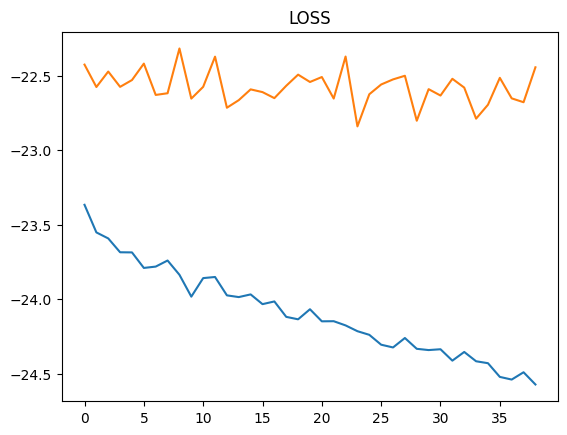

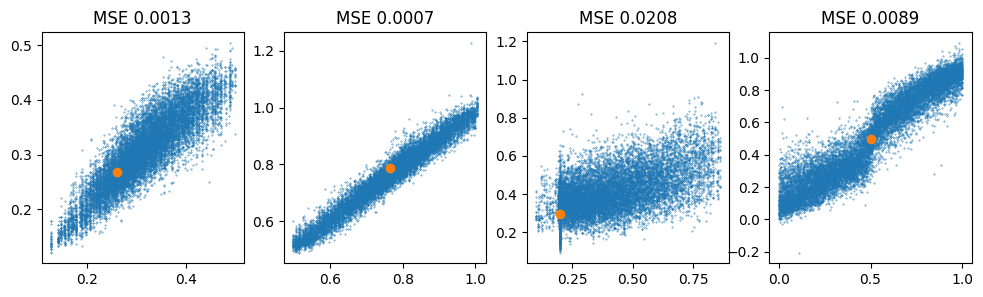

Epoch 0: Training Loss = -4.546171188354492, Validation Loss = -9.755441665649414
Epoch 1: Training Loss = -10.968398094177246, Validation Loss = -12.09315013885498
Epoch 2: Training Loss = -12.4844970703125, Validation Loss = -13.603410720825195
Epoch 3: Training Loss = -11.406365394592285, Validation Loss = -13.252480506896973
Epoch 4: Training Loss = -13.592248916625977, Validation Loss = -14.111998558044434
Epoch 5: Training Loss = -14.325798034667969, Validation Loss = -14.636540412902832
Epoch 6: Training Loss = -14.874306678771973, Validation Loss = -15.38094425201416
Epoch 7: Training Loss = -14.986184120178223, Validation Loss = -15.530355453491211
Epoch 8: Training Loss = -15.537748336791992, Validation Loss = -15.947510719299316
Epoch 9: Training Loss = -16.15148162841797, Validation Loss = -16.37220001220703
Epoch 10: Training Loss = -15.905406951904297, Validation Loss = -16.271873474121094
Epoch 11: Training Loss = -16.436901092529297, Validation Loss = -16.49984741210937

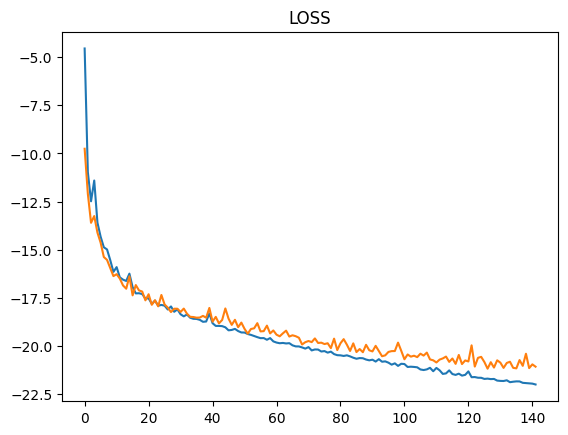

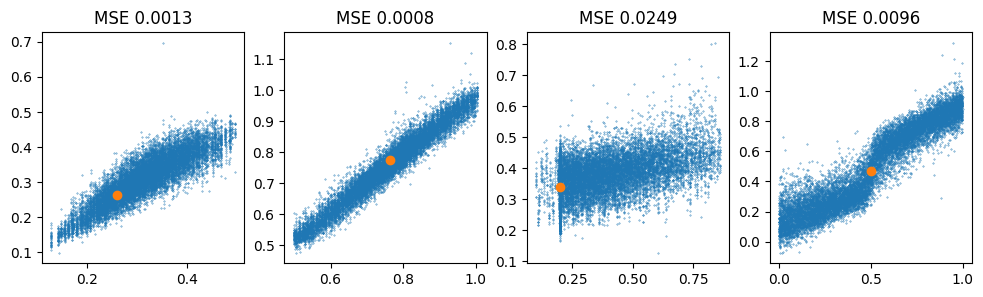

In [95]:
'''
Let's train the compression+NDEs together, from fresh start , but with MSE + MI losses
'''

rng_seq = hk.PRNGSequence(42)

model_compressor = hk.without_apply_rng(hk.transform(lambda x: Compressor()(x)))
model_logp = hk.without_apply_rng(hk.transform(lambda x,y : AffineFlow()().log_prob(x,bijector_kwargs={'nvp%d'%i:{'cond':y} for i in range(4)})))
model_sample = hk.transform(lambda n,y : AffineFlow()().sample(n, seed=hk.next_rng_key(), bijector_kwargs={'nvp%d'%i:{'cond':y} for i in range(4)}))

# copying this from before ~ ------------
params_compressor = model_compressor.init(next(rng_seq), jnp.zeros([1, len_dv]))
params_flow = model_logp.init(next(rng_seq), jnp.zeros([1, number_of_params]), jnp.zeros([1, number_of_params]))
params = hk.data_structures.merge(params_flow, params_compressor)


optimizer = optax.chain(optax.adam(1e-5))
opt_state = optimizer.init(params)


def average_loss(params, rng_key, batches):
    total_loss = 0.0
    for batch in batches:
        x, y = batch
        z = model_compressor.apply(params, y)  # Assuming you're using some pre-trained parameters or another method here
        logp = model_logp.apply(params, x, z)
        total_loss += -jnp.mean(logp)
        
    total_loss_mse = 0.0
    for batch in batches:
        x, y = batch
        z = model_compressor.apply(params, y)
        total_loss_mse += jnp.mean(weights_loss_MSE*((z - x) ** 2))
        
    avg_loss = (5*jnp.log(total_loss_mse)+total_loss)/len(batches)
    return avg_loss

@jax.jit
def update(params, rng_key, opt_state, batches):
    """Single SGD update step averaged over multiple batches."""
    loss = average_loss(params, rng_key, batches)
    grads = jax.grad(lambda p: average_loss(p, rng_key, batches))(params)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return loss, new_params, new_opt_state

@jax.jit
def validate_model(params, batches, rng_key):
    """Validate the model using average loss over multiple batches."""
    val_loss = average_loss(params, rng_key, batches)
    return val_loss

def get_batches(iterator, num_batches):
    return [next(iterator) for _ in range(num_batches)]

# Training loop adjustments


losses = []
val_losses = []
no_improve_count = 0
no_improve_threshold = 15  # Set X to the number of iterations you'll allow without any decrease in loss
best_loss = float('inf')
best_params = None

for epoch in (range(200)):
    epoch_losses = []
    for batch_index in range(number_of_batches):
        # Assuming get_batches fetches the next batch from dset
        training_batch = next(dset)
        loss, params, opt_state = update(params, next(rng_seq), opt_state, [training_batch])
        epoch_losses.append(loss)
    
    
    
    # Average the losses for the epoch
    avg_epoch_loss = np.mean(epoch_losses)
    losses.append(avg_epoch_loss)
    
    # Validation
    val_losses_accum = []
    for _ in range(number_of_batches_val):
        validation_batch = next(dset_y_val)
        val_loss = validate_model(params, [validation_batch], next(rng_seq))
        val_losses_accum.append(val_loss)
    
    # Average validation loss
    avg_val_loss = np.mean(val_losses_accum)
    val_losses.append(avg_val_loss)
    
    # Update best loss and check for early stopping
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        no_improve_count = 0
        best_params = copy.deepcopy(params)
    else:
        no_improve_count += 1

    if no_improve_count >= no_improve_threshold:
        print(f"Stopping early due to no decrease in loss after {no_improve_threshold} iterations.")
        break

    print(f"Epoch {epoch}: Training Loss = {avg_epoch_loss}, Validation Loss = {avg_val_loss}")

    
print('BEST LOSS', best_loss)
# predict ------
batch = next(dset)
x,y = batch

z_LFI = model_sample.apply(best_params, next(rng_seq), n=dv_LFI.shape[0], y=model_compressor.apply(best_params, dv_LFI))
z_target = model_sample.apply(best_params, next(rng_seq), n=1, y=model_compressor.apply(best_params, np.array(dv_target).reshape(1,-1)))
z_target = z_target[0]




# predict ------
batch = next(dset)
x,y = batch

z_LFI = model_compressor.apply(best_params, dv_LFI)
z_target = model_compressor.apply(best_params, np.array(dv_target).reshape(1,-1))

#z_LFI = model_compressor.apply(best_params_compressor, dv_LFI)
#z_target = model_compressor.apply(best_params_compressor, np.array(dv_target).reshape(1,-1))

z_target = z_target[0]


plt.title('LOSS')
plt.plot(losses)
plt.plot(val_losses)
#plt.ylim([-10,2])
plt.show()


MSE = np.mean((z_LFI[:,0]-pars_LFI[:,0])**2)
MSE1 = np.mean((z_LFI[:,1]-pars_LFI[:,1])**2)
MSE2 = np.mean((z_LFI[:,2]-pars_LFI[:,2])**2)
MSE3 = np.mean((z_LFI[:,3]-pars_LFI[:,3])**2)

fig, ax = plt.subplots(1,4,sharex=False,sharey=False, figsize=(12,3)) 
ax[0].scatter(pars_LFI[:,0],z_LFI[:,0],s=0.1)
ax[0].scatter([0.26],[z_target[0]])
ax[0].set_title('MSE {0:2.4f}'.format(MSE))
ax[1].set_title('MSE {0:2.4f}'.format(MSE1))
ax[1].scatter(pars_LFI[:,1],z_LFI[:,1],s=0.1)
ax[1].scatter([0.82*np.sqrt(0.26/0.3)],[z_target[1]])
ax[2].set_title('MSE {0:2.4f}'.format(MSE2))
ax[2].scatter(pars_LFI[:,2],z_LFI[:,2],s=0.1)
ax[2].scatter([-1.+1.2],[z_target[2]])
ax[3].set_title('MSE {0:2.4f}'.format(MSE3))
ax[3].scatter(pars_LFI[:,3],z_LFI[:,3],s=0.1)
ax[3].scatter([0.5],[z_target[3]])
plt.show()



compressed_DV_VMIM = dict()  
compressed_DV_VMIM[statistic] = dict()
compressed_DV_VMIM[statistic]['params'] = np.array(pars_LFI)
compressed_DV_VMIM[statistic]['DV'] =  np.array(z_LFI)
compressed_DV_VMIM[statistic]['target'] =  np.array(z_target)

In [98]:
'''
Let's train the compression+NDEs together, from beste MSE start , but with only MI loss
'''

rng_seq = hk.PRNGSequence(42)

model_compressor = hk.without_apply_rng(hk.transform(lambda x: Compressor()(x)))
model_logp = hk.without_apply_rng(hk.transform(lambda x,y : AffineFlow()().log_prob(x,bijector_kwargs={'nvp%d'%i:{'cond':y} for i in range(4)})))
model_sample = hk.transform(lambda n,y : AffineFlow()().sample(n, seed=hk.next_rng_key(), bijector_kwargs={'nvp%d'%i:{'cond':y} for i in range(4)}))

# copying this from before ~ ------------
#params_compressor = model_compressor.init(next(rng_seq), jnp.zeros([1, len_dv]))
#params_flow = model_logp.init(next(rng_seq), jnp.zeros([1, number_of_params]), jnp.zeros([1, number_of_params]))
params_compressor = copy.deepcopy(best_params_compressor)
params_flow = copy.deepcopy(best_params_flow)


params = hk.data_structures.merge(params_flow, params_compressor)


optimizer = optax.chain(optax.adam(1e-5))
opt_state = optimizer.init(params)


def average_loss(params, rng_key, batches):
    total_loss = 0.0
    for batch in batches:
        x, y = batch
        z = model_compressor.apply(params, y)  # Assuming you're using some pre-trained parameters or another method here
        logp = model_logp.apply(params, x, z)
        total_loss += -jnp.mean(logp)
        
    #total_loss_mse = 0.0
    #for batch in batches:
    #    x, y = batch
    #    z = model_compressor.apply(params, y)
    #    total_loss_mse += jnp.mean(weights_loss_MSE*((z - x) ** 2))
        
    avg_loss = (total_loss)/len(batches)
    return avg_loss

@jax.jit
def update(params, rng_key, opt_state, batches):
    """Single SGD update step averaged over multiple batches."""
    loss = average_loss(params, rng_key, batches)
    grads = jax.grad(lambda p: average_loss(p, rng_key, batches))(params)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return loss, new_params, new_opt_state

@jax.jit
def validate_model(params, batches, rng_key):
    """Validate the model using average loss over multiple batches."""
    val_loss = average_loss(params, rng_key, batches)
    return val_loss

def get_batches(iterator, num_batches):
    return [next(iterator) for _ in range(num_batches)]

# Training loop adjustments


losses = []
val_losses = []
no_improve_count = 0
no_improve_threshold = 15  # Set X to the number of iterations you'll allow without any decrease in loss
best_loss = float('inf')
best_params = None

for epoch in (range(150)):
    epoch_losses = []
    for batch_index in range(number_of_batches):
        # Assuming get_batches fetches the next batch from dset
        training_batch = next(dset)
        loss, params, opt_state = update(params, next(rng_seq), opt_state, [training_batch])
        epoch_losses.append(loss)
    
    
    
    # Average the losses for the epoch
    avg_epoch_loss = np.mean(epoch_losses)
    losses.append(avg_epoch_loss)
    
    # Validation
    val_losses_accum = []
    for _ in range(number_of_batches_val):
        validation_batch = next(dset_y_val)
        val_loss = validate_model(params, [validation_batch], next(rng_seq))
        val_losses_accum.append(val_loss)
    
    # Average validation loss
    avg_val_loss = np.mean(val_losses_accum)
    val_losses.append(avg_val_loss)
    
    # Update best loss and check for early stopping
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        no_improve_count = 0
        best_params = copy.deepcopy(params)
    else:
        no_improve_count += 1

    if no_improve_count >= no_improve_threshold:
        print(f"Stopping early due to no decrease in loss after {no_improve_threshold} iterations.")
        break

    print(f"Epoch {epoch}: Training Loss = {avg_epoch_loss}, Validation Loss = {avg_val_loss}")

    
print('BEST LOSS', best_loss)
# predict ------
batch = next(dset)
x,y = batch

z_LFI = model_sample.apply(best_params, next(rng_seq), n=dv_LFI.shape[0], y=model_compressor.apply(best_params, dv_LFI))
z_target = model_sample.apply(best_params, next(rng_seq), n=1, y=model_compressor.apply(best_params, np.array(dv_target).reshape(1,-1)))
z_target = z_target[0]



Epoch 0: Training Loss = -6.760960578918457, Validation Loss = -6.433164119720459
Epoch 1: Training Loss = -6.818491458892822, Validation Loss = -6.51054048538208
Epoch 2: Training Loss = -6.82603645324707, Validation Loss = -6.350014686584473
Epoch 3: Training Loss = -6.856629371643066, Validation Loss = -6.468803882598877
Epoch 4: Training Loss = -6.867604732513428, Validation Loss = -6.447455406188965
Epoch 5: Training Loss = -6.91209077835083, Validation Loss = -6.429592609405518
Epoch 6: Training Loss = -6.87723445892334, Validation Loss = -6.487182140350342
Epoch 7: Training Loss = -6.901666164398193, Validation Loss = -6.427414417266846
Epoch 8: Training Loss = -6.936042308807373, Validation Loss = -6.568302154541016
Epoch 9: Training Loss = -6.959182262420654, Validation Loss = -6.511045932769775
Epoch 10: Training Loss = -6.942312240600586, Validation Loss = -6.4334235191345215
Epoch 11: Training Loss = -6.985891819000244, Validation Loss = -6.487767219543457
Epoch 12: Trainin

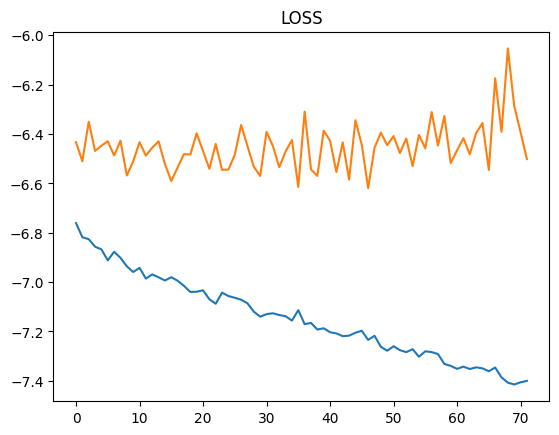

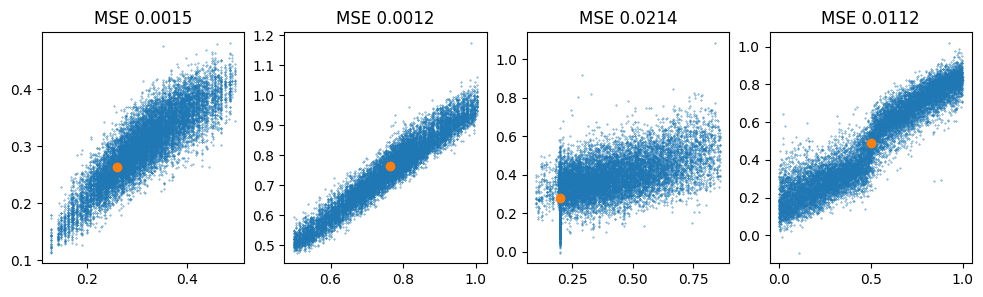

In [100]:
# predict ------
z_LFI = model_compressor.apply(best_params, dv_LFI)
z_target = model_compressor.apply(best_params, np.array(dv_target).reshape(1,-1))

#z_LFI = model_compressor.apply(best_params_compressor, dv_LFI)
#z_target = model_compressor.apply(best_params_compressor, np.array(dv_target).reshape(1,-1))

z_target = z_target[0]


plt.title('LOSS')
plt.plot(losses)
plt.plot(val_losses)
#plt.ylim([-10,2])
plt.show()


MSE = np.mean((z_LFI[:,0]-pars_LFI[:,0])**2)
MSE1 = np.mean((z_LFI[:,1]-pars_LFI[:,1])**2)
MSE2 = np.mean((z_LFI[:,2]-pars_LFI[:,2])**2)
MSE3 = np.mean((z_LFI[:,3]-pars_LFI[:,3])**2)

fig, ax = plt.subplots(1,4,sharex=False,sharey=False, figsize=(12,3)) 
ax[0].scatter(pars_LFI[:,0],z_LFI[:,0],s=0.1)
ax[0].scatter([0.26],[z_target[0]])
ax[0].set_title('MSE {0:2.4f}'.format(MSE))
ax[1].set_title('MSE {0:2.4f}'.format(MSE1))
ax[1].scatter(pars_LFI[:,1],z_LFI[:,1],s=0.1)
ax[1].scatter([0.82*np.sqrt(0.26/0.3)],[z_target[1]])
ax[2].set_title('MSE {0:2.4f}'.format(MSE2))
ax[2].scatter(pars_LFI[:,2],z_LFI[:,2],s=0.1)
ax[2].scatter([-1.+1.2],[z_target[2]])
ax[3].set_title('MSE {0:2.4f}'.format(MSE3))
ax[3].scatter(pars_LFI[:,3],z_LFI[:,3],s=0.1)
ax[3].scatter([0.5],[z_target[3]])
plt.show()



compressed_DV_VMIM = dict()  
compressed_DV_VMIM[statistic] = dict()
compressed_DV_VMIM[statistic]['params'] = np.array(pars_LFI)
compressed_DV_VMIM[statistic]['DV'] =  np.array(z_LFI)
compressed_DV_VMIM[statistic]['target'] =  np.array(z_target)

In [ ]:
# try to increase the batch size here and in NN and see what changes ----------
# I'd suggest to use back the 128 batch size and simply compute the loss function multiple times and get an average.


# NN

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, ReLU
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Input, Add
from tensorflow.keras.callbacks import EarlyStopping



def simple_model_2d_2k(input_size, lr=1e-4):
    # create model
    model = Sequential()
    model.add(Dense(1900, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1500, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(900, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(500, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(100, input_dim=input_size, kernel_initializer='normal'))
    model.add(ReLU())
    model.add(Dense(100, input_dim=input_size, kernel_initializer='normal'))
    model.add(ReLU())
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(optimizer=Adam(lr=lr), loss='mse')
    return model


def simple_model_2d_1k(input_size, lr=1e-4):
    # create model
    model = Sequential()
    model.add(Dense(900, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(800, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    # model.add(ReLU())
    model.add(Dense(100, input_dim=input_size, kernel_initializer='normal'))
    # model.add(LeakyReLU(alpha=0.01))
    model.add(ReLU())
    model.add(Dense(100, input_dim=input_size, kernel_initializer='normal'))
    # model.add(LeakyReLU(alpha=0.01))
    model.add(ReLU())
    # model.add(ReLU())
    model.add(Dense(1, kernel_initializer='normal'))

    #model.compile(optimizer=Adam(lr=lr), loss='mse')#loss='mean_absolute_error')#loss='mse')
    model.compile(optimizer=Adam(lr=lr), loss='mse')#loss='mse')
    return model



def simple_model_2d_400(input_size, lr=1e-4):
    # create model
    model = Sequential()
    model.add(Dense(400, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(300, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    # model.add(ReLU())
    model.add(Dense(100, input_dim=input_size, kernel_initializer='normal'))
    # model.add(LeakyReLU(alpha=0.01))
    model.add(ReLU())
    model.add(Dense(50, input_dim=input_size, kernel_initializer='normal'))
    # model.add(LeakyReLU(alpha=0.01))
    model.add(ReLU())
    # model.add(ReLU())
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(optimizer=Adam(lr=lr), loss='mse')#loss='mean_absolute_error')#loss='mse')
    return model


In [57]:
compressed_DV_NN = dict()
compressed_DV_NN[statistic] = dict()

parameters = ['Om','S8','w','A']

for i, parameter in enumerate(parameters):
    if parameter == 'Om':
        mask_parameter = np.array([True,False,False,False])[:number_of_params]
    if parameter == 'S8':
        mask_parameter = np.array([False,True,False,False])[:number_of_params]
    if parameter == 'w':
        mask_parameter = np.array([False,False,True,False])[:number_of_params]
    if parameter == 'A':
        mask_parameter = np.array([False,False,False,True])[:number_of_params]


    regression_power = simple_model_2d_1k(len_dv, lr=1e-5)


    iter_ = 1
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min', restore_best_weights=True)

    for round_ in range(iter_):
        print ('ROUND ', round_)
        
        numerical_noise = 0.*np.random.normal(np.array(dv_train)*0.,2e-3)
        history_2d_power = regression_power.fit((np.array(dv_train)+numerical_noise),
                   np.array(pars_train)[:,mask_parameter],
                   epochs =150,batch_size = 32, shuffle=True,
                   validation_data = ((np.array(dv_val)[:,:]),
                                      np.array(pars_val)[:,mask_parameter]),callbacks=[early_stopping])
        
        
    # Check if early stopping was triggered
        if early_stopping.stopped_epoch > 0:
            print(f"Early stopping triggered at round {round_}, stopping further training.")
            break  # Exit the loop, skipping subsequent rounds


    #regression_power.save_weights((output_folder+'/compression_models/'+statistic+'_'+parameter))

    compressed_data_v  = np.clip(regression_power.predict( np.array(dv_LFI)), -1., 1.5)
    compressed_data_target  = np.clip(regression_power.predict( np.array(dv_target).reshape(1,-1)), -1., 1.5)[0][0]




    if i == 0 :
        compressed_DV_NN[statistic]['params'] = np.array(pars_LFI[:,mask_parameter])[:,0]
        compressed_DV_NN[statistic]['DV'] = compressed_data_v[:,0]
        compressed_DV_NN[statistic]['target'] = compressed_data_target
    else:
        compressed_DV_NN[statistic]['params'] = np.vstack([compressed_DV_NN[statistic]['params'],np.array(pars_LFI[:,mask_parameter])[:,0]])
        compressed_DV_NN[statistic]['DV'] = np.vstack([compressed_DV_NN[statistic]['DV'],compressed_data_v[:,0]])
        compressed_DV_NN[statistic]['target'] = np.vstack([compressed_DV_NN[statistic]['target'],compressed_data_target])


compressed_DV_NN[statistic]['DV'] = compressed_DV_NN[statistic]['DV'].T
compressed_DV_NN[statistic]['params'] = compressed_DV_NN[statistic]['params'].T
compressed_DV_NN[statistic]['target'] = compressed_DV_NN[statistic]['target'].T[0]

ROUND  0
Epoch 1/150
679/679 [==============================] - 4s 5ms/step - loss: 0.0539 - val_loss: 0.0412
Epoch 2/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0374 - val_loss: 0.0356
Epoch 3/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0356 - val_loss: 0.0326
Epoch 4/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0346 - val_loss: 0.0452
Epoch 5/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0342 - val_loss: 0.0326
Epoch 6/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0335 - val_loss: 0.0359
Epoch 7/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0332 - val_loss: 0.0328
Epoch 8/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0330 - val_loss: 0.0326
Epoch 9/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0330 - val_loss: 0.0315
Epoch 10/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0330

ROUND  0
Epoch 1/150
679/679 [==============================] - 4s 5ms/step - loss: 0.0553 - val_loss: 0.0347
Epoch 2/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0381 - val_loss: 0.0311
Epoch 3/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0343 - val_loss: 0.0305
Epoch 4/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0325 - val_loss: 0.0291
Epoch 5/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0314 - val_loss: 0.0317
Epoch 6/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0313 - val_loss: 0.0280
Epoch 7/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0302 - val_loss: 0.0278
Epoch 8/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0307 - val_loss: 0.0308
Epoch 9/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0291 - val_loss: 0.0286
Epoch 10/150
679/679 [==============================] - 3s 5ms/step - loss: 0.0291

ROUND  0
Epoch 1/150
679/679 [==============================] - 4s 5ms/step - loss: 0.1432 - val_loss: 0.1464
Epoch 2/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1369 - val_loss: 0.1325
Epoch 3/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1346 - val_loss: 0.1348
Epoch 4/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1328 - val_loss: 0.1298
Epoch 5/150
679/679 [==============================] - 4s 5ms/step - loss: 0.1317 - val_loss: 0.1271
Epoch 6/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1302 - val_loss: 0.1261
Epoch 7/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1300 - val_loss: 0.1342
Epoch 8/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1298 - val_loss: 0.1253
Epoch 9/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1290 - val_loss: 0.1252
Epoch 10/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1279

ROUND  0
Epoch 1/150
679/679 [==============================] - 4s 5ms/step - loss: 0.1488 - val_loss: 0.1103
Epoch 2/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1167 - val_loss: 0.1175
Epoch 3/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1125 - val_loss: 0.0990
Epoch 4/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1088 - val_loss: 0.1028
Epoch 5/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1060 - val_loss: 0.1038
Epoch 6/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1056 - val_loss: 0.0964
Epoch 7/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1044 - val_loss: 0.1184
Epoch 8/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1022 - val_loss: 0.1066
Epoch 9/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1023 - val_loss: 0.1026
Epoch 10/150
679/679 [==============================] - 3s 5ms/step - loss: 0.1007

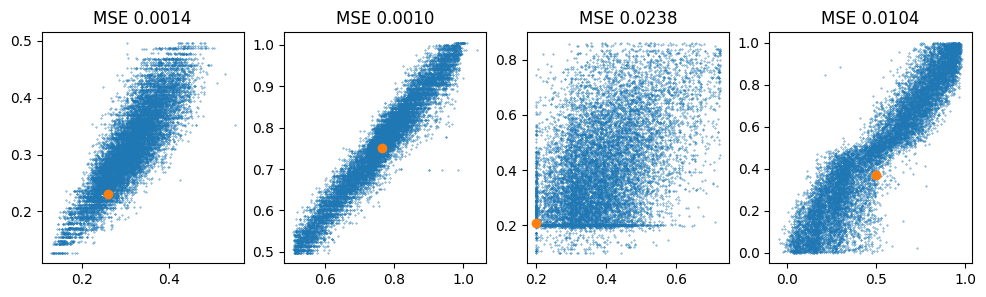

In [59]:
MSE = np.mean((compressed_DV_NN[statistic]['DV'][:,0]-compressed_DV_NN[statistic]['params'][:,0])**2)
MSE1 = np.mean((compressed_DV_NN[statistic]['DV'][:,1]-compressed_DV_NN[statistic]['params'][:,1])**2)
MSE2 = np.mean((compressed_DV_NN[statistic]['DV'][:,2]-compressed_DV_NN[statistic]['params'][:,2])**2)
MSE3 = np.mean((compressed_DV_NN[statistic]['DV'][:,3]-compressed_DV_NN[statistic]['params'][:,3])**2)

fig, ax = plt.subplots(1,4,sharex=False,sharey=False, figsize=(12,3)) 


#fig, ax = plt.subplots(1,2,sharex=False,sharey=False, figsize=(7,3)) 
ax[0].scatter(compressed_DV_NN[statistic]['DV'][:,0],compressed_DV_NN[statistic]['params'][:,0],s=0.1)
ax[0].scatter([0.26],[z_target[0]])
ax[0].set_title('MSE {0:2.4f}'.format(MSE))
ax[1].scatter(compressed_DV_NN[statistic]['DV'][:,1],compressed_DV_NN[statistic]['params'][:,1],s=0.1)
ax[1].scatter([0.82*np.sqrt(0.26/0.3)],[z_target[1]])
ax[1].set_title('MSE {0:2.4f}'.format(MSE1))

ax[2].scatter(compressed_DV_NN[statistic]['DV'][:,2],compressed_DV_NN[statistic]['params'][:,2],s=0.1)
ax[2].scatter([-1+1.2],[z_target[2]])
ax[2].set_title('MSE {0:2.4f}'.format(MSE2))

ax[3].scatter(compressed_DV_NN[statistic]['DV'][:,3],compressed_DV_NN[statistic]['params'][:,3],s=0.1)
ax[3].scatter([0.5],[z_target[3]])
ax[3].set_title('MSE {0:2.4f}'.format(MSE3))
plt.show()


# NN2

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LeakyReLU, ReLU, Input, Concatenate
from tensorflow.keras.optimizers import Adam

def create_branch(input_shape):
    # Input layer for the branch
    inputs = Input(shape=(input_shape,))
    # First dense layer
    x = Dense(900, kernel_initializer='normal')(inputs)
    x = LeakyReLU(alpha=0.01)(x)
    # Second dense layer
    x = Dense(800, kernel_initializer='normal')(x)
    x = LeakyReLU(alpha=0.01)(x)
    # Third dense layer
    x = Dense(100, kernel_initializer='normal')(x)
    x = ReLU()(x)
    # Fourth dense layer
    x = Dense(100, kernel_initializer='normal')(x)
    x = ReLU()(x)
    # Output layer for the branch
    output = Dense(1, kernel_initializer='normal')(x)
    return Model(inputs=inputs, outputs=output)

def create_combined_model(input_size, lr=1e-4, num_branches=4):
    # Create input layer
    inputs = Input(shape=(input_size,))
    # Create branches
    branches = [create_branch(input_size) for _ in range(num_branches)]
    # Get the output of each branch
    branch_outputs = [branch(inputs) for i, branch in enumerate(branches)]
    # Concatenate all branch outputs
    concatenated = Concatenate()(branch_outputs)
    # Create combined model
    model = Model(inputs=inputs, outputs=concatenated)
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss=lambda y_true, y_pred: weighted_mse_loss(y_true, y_pred))
    return model

def weighted_mse_loss(y_true, y_pred, weights = weights_loss_MSE):
    # Calculate the MSE loss for each parameter
    squared_difference = tf.square(y_true - y_pred)
    # Apply weights
    weighted_squared_difference = squared_difference * weights
    # Return the mean squared error across all parameters
    return tf.reduce_mean(weighted_squared_difference, axis=-1)



In [21]:
compressed_DV_NN2 = dict()
compressed_DV_NN2[statistic] = dict()



regression_power = create_combined_model(len_dv, lr=1e-5,num_branches=number_of_params)


iter_ = 1
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min', restore_best_weights=True)

for round_ in range(iter_):
    print ('ROUND ', round_)

    numerical_noise = 0.*np.random.normal(np.array(dv_train)*0.,2e-3)
    history_2d_power = regression_power.fit((np.array(dv_train)+numerical_noise),
               np.array(pars_train)[:,:],
               epochs =150,batch_size = 32, shuffle=True,
               validation_data = ((np.array(dv_val)[:,:]),
                                  np.array(pars_val)[:,:]),callbacks=[early_stopping])


# Check if early stopping was triggered
    if early_stopping.stopped_epoch > 0:
        print(f"Early stopping triggered at round {round_}, stopping further training.")
        break  # Exit the loop, skipping subsequent rounds


#regression_power.save_weights((output_folder+'/compression_models/'+statistic+'_'+parameter))

compressed_data_v  = np.clip(regression_power.predict( np.array(dv_LFI)), -1., 1.5)
compressed_data_target  = np.clip(regression_power.predict( np.array(dv_target).reshape(1,-1)), -1., 1.5)[0][0]




compressed_DV_NN2[statistic]['params'] = np.array(pars_LFI[:,:])
compressed_DV_NN2[statistic]['DV'] = compressed_data_v
compressed_DV_NN2[statistic]['target'] = compressed_data_target


ROUND  0
Epoch 1/150
679/679 [==============================] - 25s 33ms/step - loss: 1.0513 - val_loss: 0.2947
Epoch 2/150
679/679 [==============================] - 19s 29ms/step - loss: 0.2396 - val_loss: 0.1775
Epoch 3/150
679/679 [==============================] - 20s 30ms/step - loss: 0.1682 - val_loss: 0.1408
Epoch 4/150
679/679 [==============================] - 23s 34ms/step - loss: 0.1341 - val_loss: 0.1066
Epoch 5/150
679/679 [==============================] - 15s 23ms/step - loss: 0.1117 - val_loss: 0.0908
Epoch 6/150
679/679 [==============================] - 25s 36ms/step - loss: 0.0982 - val_loss: 0.0823
Epoch 7/150
679/679 [==============================] - 18s 26ms/step - loss: 0.0881 - val_loss: 0.0757
Epoch 8/150
679/679 [==============================] - 21s 31ms/step - loss: 0.0809 - val_loss: 0.0738
Epoch 9/150
679/679 [==============================] - 19s 29ms/step - loss: 0.0759 - val_loss: 0.0683
Epoch 10/150
679/679 [==============================] - 19s 28ms

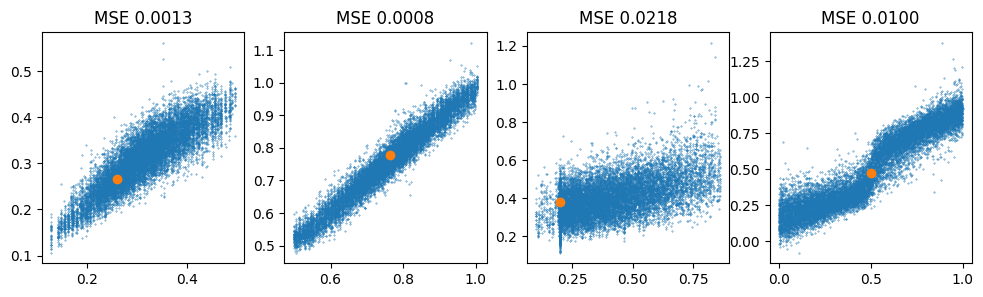

In [23]:
MSE = np.mean((compressed_DV_NN2[statistic]['DV'][:,0]-compressed_DV_NN2[statistic]['params'][:,0])**2)
MSE1 = np.mean((compressed_DV_NN2[statistic]['DV'][:,1]-compressed_DV_NN2[statistic]['params'][:,1])**2)
MSE2 = np.mean((compressed_DV_NN2[statistic]['DV'][:,2]-compressed_DV_NN2[statistic]['params'][:,2])**2)
MSE3 = np.mean((compressed_DV_NN2[statistic]['DV'][:,3]-compressed_DV_NN2[statistic]['params'][:,3])**2)

fig, ax = plt.subplots(1,4,sharex=False,sharey=False, figsize=(12,3)) 

#fig, ax = plt.subplots(1,2,sharex=False,sharey=False, figsize=(7,3)) 
ax[0].scatter(compressed_DV_NN2[statistic]['params'][:,0],compressed_DV_NN2[statistic]['DV'][:,0],s=0.1)
ax[0].scatter([0.26],[z_target[0]])
ax[0].set_title('MSE {0:2.4f}'.format(MSE))
ax[1].scatter(compressed_DV_NN2[statistic]['params'][:,1],compressed_DV_NN2[statistic]['DV'][:,1],s=0.1)
ax[1].scatter([0.82*np.sqrt(0.26/0.3)],[z_target[1]])
ax[1].set_title('MSE {0:2.4f}'.format(MSE1))

ax[2].scatter(compressed_DV_NN2[statistic]['params'][:,2],compressed_DV_NN2[statistic]['DV'][:,2],s=0.1)
ax[2].scatter([-1+1.2],[z_target[2]])
ax[2].set_title('MSE {0:2.4f}'.format(MSE2))

ax[3].scatter(compressed_DV_NN2[statistic]['params'][:,3],compressed_DV_NN2[statistic]['DV'][:,3],s=0.1)
ax[3].scatter([0.5],[z_target[3]])
ax[3].set_title('MSE {0:2.4f}'.format(MSE3))
plt.show()


# 0.0013,0.0008,

# MOPED

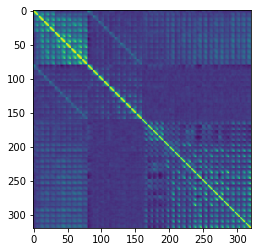

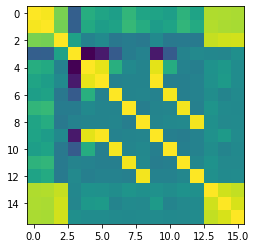

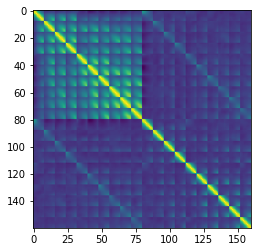

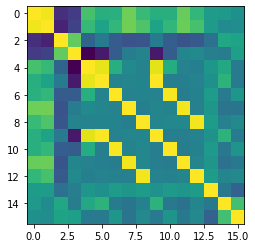

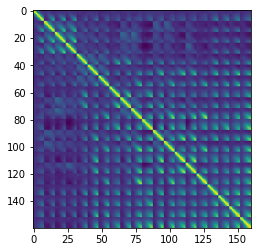

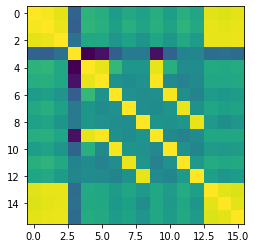

In [10]:
from numpy.random import default_rng

# normalise the entries for the covariance and the derivatives
# increaments of the parameters for the numerical derivatives
# normalise the entries for the covariance and the derivatives
# increaments of the parameters for the numerical derivatives
delta = dict()
delta['delta_Om' ] = 0.02
delta['delta_s8' ] = 0.03
delta['delta_w0' ] = 0.1
delta['delta_A'  ] = 0.2
delta['delta_E'  ] = 0.2
delta['delta_dm1'] = 0.2
delta['delta_dm2'] = 0.2
delta['delta_dm3'] = 0.2
delta['delta_dm4'] = 0.2
delta['delta_dz1'] = 0.2
delta['delta_dz2'] = 0.2
delta['delta_dz3'] = 0.2
delta['delta_dz4'] = 0.2
delta['delta_Ob' ] = 0.002
delta['delta_ns' ] = 0.04
delta['delta_H0' ] = 4.0

compressed_DV_MOPED = dict()

# Load derivatives & covariance matrix
derivatives_dict = np.load('/global/cfs/cdirs/des/mgatti/CMB_lensing/DV/SBI_forecast/MOPED_derivatives.npy',allow_pickle=True).item()

for statistic in ['WL_23','WL_2','WL_3']:

    '''
    Data set preparation -------------------------------------------
    '''
    additional_mask = stat[statistic]['params'][:,2]>0.1
    # these are the pars/DV that will be used for the compression.
    pars = np.array(stat[statistic]['params'][mask&additional_mask,:number_of_params])
    dv = np.array(stat[statistic]['dv'][mask&additional_mask,:])

    # these are the pars/DV that will be used for the LFI step later on
    pars_LFI = np.array(stat[statistic]['params'][(~mask)&additional_mask,:number_of_params])
    dv_LFI = np.array(stat[statistic]['dv'][(~mask)&additional_mask,:])


    len_dv = dv.shape[1]  
    samples = dv.shape[0]

    # split into training & validation for the compression -------
    rng = default_rng()
    numbers = rng.choice(samples , size=3000, replace=False)
    special = np.in1d(np.arange(samples ),numbers)


    pars_train = np.array(pars[~special])
    pars_val =  np.array(pars[special])
    dv_train = np.array(dv[~special])
    dv_val = np.array(dv[special])

    # normalise the DV
    dv_val =    np.clip(0.5+0.2 * ( dv_val-np.median( dv,axis=0)) / np.std( dv, axis=0) ,-0.5,1.5)
    dv_train =  np.clip(0.5+0.2 * ( dv_train-np.median( dv,axis=0)) / np.std( dv, axis=0) ,-0.5,1.5)
    dv_LFI =    np.clip(0.5+0.2 * ( dv_LFI-np.median( dv,axis=0)) / np.std( dv, axis=0) ,-0.5,1.5)
    dv_target = np.clip(0.5+0.2 * ( target[statistic]['dv']-np.median( dv,axis=0)) / np.std( dv, axis=0) ,-0.5,1.5)



    compressed_DV_MOPED[statistic] = dict()
    
    
    
    
    derivatives = dict()
    dv_cov  = np.clip(0.5+0.2 * ( derivatives_dict[statistic]['cov']-np.median( dv,axis=0)) / np.std( dv, axis=0) ,-0.5,1.5)
    for key in delta.keys():
        dv_p  = np.clip(0.5+0.2 * ( derivatives_dict[statistic][key][0]-np.median( dv,axis=0)) / np.std( dv, axis=0) ,-0.5,1.5)
        dv_m  = np.clip(0.5+0.2 * ( derivatives_dict[statistic][key][1]-np.median( dv,axis=0)) / np.std( dv, axis=0) ,-0.5,1.5)
        derivatives[key] = [dv_p,dv_m]


    number_of_parameters = 4


    cov_matrix = np.cov(dv_cov.T)
    inv_cov = np.linalg.inv(cov_matrix)
    deriv = dict()
    for key in derivatives.keys():
        deriv[key] = np.mean((derivatives[key][0]-derivatives[key][1]),axis=0)/delta[key]
    deriv['S8'] = deriv['delta_s8']/ 0.9309  + deriv['delta_Om']* 0.664

    pars_ = ['delta_Om' ,'S8' ,'delta_w0' ,'delta_A'  ,'delta_E'  ,'delta_dm1','delta_dm2','delta_dm3','delta_dm4','delta_dz1','delta_dz2','delta_dz3','delta_dz4','delta_Ob' ,'delta_ns' ,'delta_H0' ]

    transf_matrix = np.zeros((len(pars_),(cov_matrix.shape[0])))
    for count, p in enumerate(pars_):
        transf_matrix[count,:]= np.matmul(deriv[p],inv_cov).T         

    # normalisation for ease of LFI (probbaly not needed if the DVs are normalised to begin with --
    std_ = np.std(np.matmul(transf_matrix,dv.T).T,axis=0)  
    #transf_matrix = (transf_matrix.T/std_).T 
    compressed_dv = np.matmul(transf_matrix,dv_LFI.T).T#-median+0.5
    compressed_dv_target = np.matmul(transf_matrix,dv_target.T).T#-median+0.5


    compressed_DV_MOPED[statistic]['params'] = np.array(pars_LFI)
    compressed_DV_MOPED[statistic]['DV'] =  np.array(compressed_dv)
    compressed_DV_MOPED[statistic]['target'] =  np.array(compressed_dv_target)

    
    cov_ = copy.deepcopy(cov_matrix)
    corr_ = np.zeros((cov_.shape[0],cov_.shape[0]))
    for i in range(cov_.shape[0]):
        for j in range(cov_.shape[0]):
            corr_[i,j] = cov_[i,j]/np.sqrt(cov_[i,i]*cov_[j,j])
    plt.imshow(corr_)
    plt.show()
    
    cov_ = np.cov(np.matmul(transf_matrix,dv_cov.T))
    corr_ = np.zeros((cov_.shape[0],cov_.shape[0]))
    for i in range(cov_.shape[0]):
        for j in range(cov_.shape[0]):
            corr_[i,j] = cov_[i,j]/np.sqrt(cov_[i,i]*cov_[j,j])
    plt.imshow(corr_)
    plt.show()



delta_Om


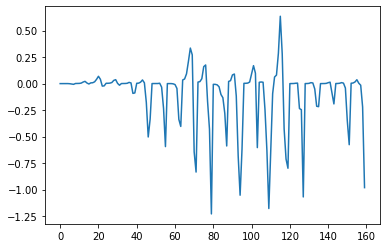

delta_s8


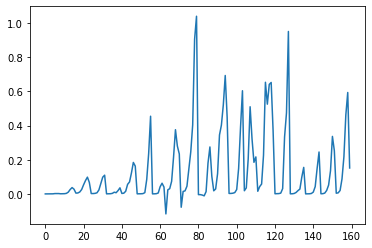

delta_w0


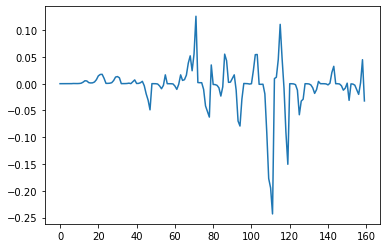

delta_A


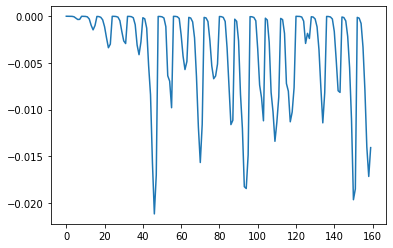

delta_E


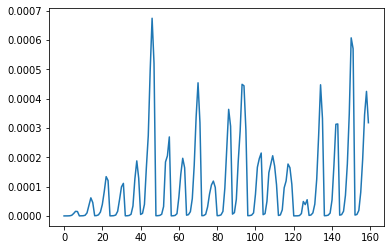

delta_dm1


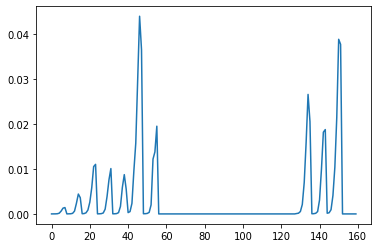

delta_dm2


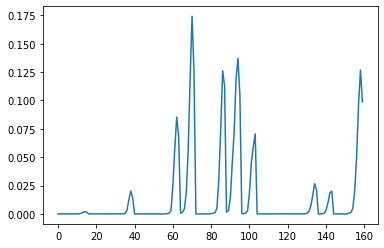

delta_dm3


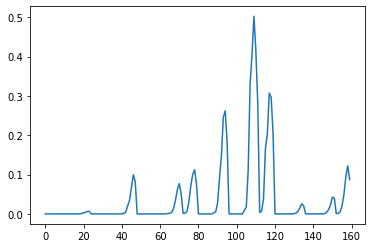

delta_dm4


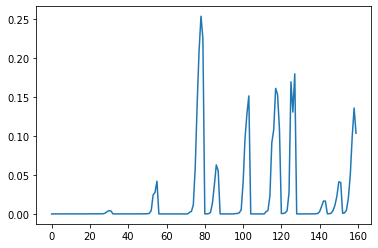

delta_dz1


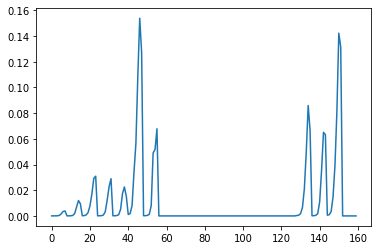

delta_dz2


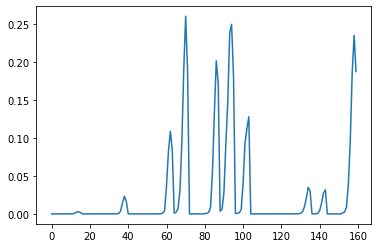

delta_dz3


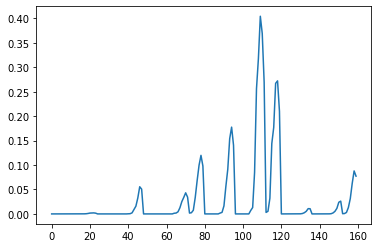

delta_dz4


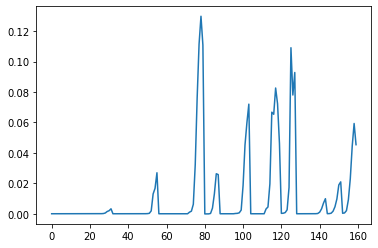

delta_Ob


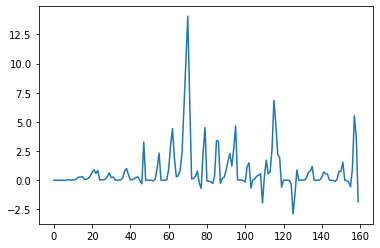

delta_ns


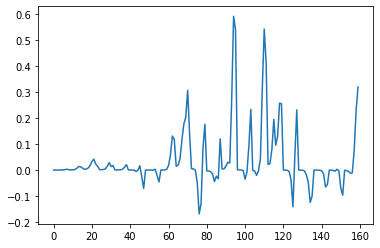

delta_H0


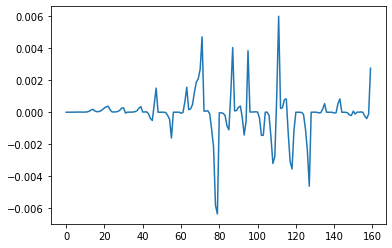

S8


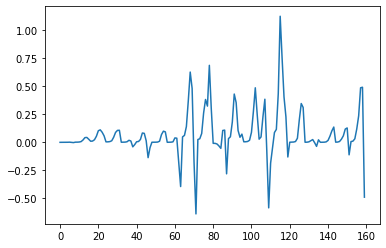

In [18]:
for key in deriv.keys():
    print (key)
    plt.plot(deriv[key])
    plt.show()

# MOPED theory

In [33]:
import healpy as hp
name_file ='/global/cfs/cdirs/des/mgatti/Moments_analysis/mode_coupling_matrix_NaMaster_3arcmin_sm_{0}_{1}.npy'.format(1024,512)
[M,Mtot] = np.load(name_file,allow_pickle=True)
MEE=M[:1000,:][:,:1000]
cl_pix = hp.sphtfunc.pixwin(512)

MB = (Mtot[3::4,:][:,::4])
MBB = MB[:1000,:][:,:1000]


In [34]:
from Moments_analysis.compute_theory import compute_masked_2m
import scipy
import healpy as hp
smoothing_scales = np.array([8.2,13.1,21.0,33.6,54.,86.,138,221.])
increments = dict()
increments['fiducial'] = [0,0.0,0.,0.]
increments['s8_1'] = [0,0.01,0.,0.]
increments['s8_2'] = [0,0.02,0.,0.]
increments['s8_m1'] = [0,-0.01,0.,0.]
increments['s8_m2'] = [0,-0.02,0.,0.]
increments['om_1'] =  [0.01, 0.,0.,0.]
increments['om_2'] =  [0.02, 0.,0.,0.]
increments['om_m1'] = [-0.01,0.,0.,0.]
increments['om_m2'] = [-0.02,0.,0.,0.]

increments['w_1'] =  [0.,0.,0.01, 0.]
increments['w_2'] =  [0.,0.,0.02, 0.]
increments['w_m1'] = [0.,0.,-0.01,0.]
increments['w_m2'] = [0.,0.,-0.02,0.]

increments['A_1'] =  [0.,0.,0.,0.01, 0.]
increments['A_2'] =  [0.,0.,0.,0.02, 0.]
increments['A_m1'] = [0.,0.,0.,-0.01,0.]
increments['A_m2'] = [0.,0.,0.,-0.02,0.]


#0.04,0.04,0.05,0.3,0.3,0.01,0.01,0.01,0.01]

increments['E_1'] =  [0.,0.,0.,0.,0.3  ,0.,0.,0.,0.,0. ]
increments['E_2'] =  [0.,0.,0.,0.,0.6  ,0.,0.,0.,0.,0. ]
increments['E_m1'] = [0.,0.,0.,-0.,-0.3,0.,0.,0.,0.,0.]
increments['E_m2'] = [0.,0.,0.,-0.,-0.6,0.,0.,0.,0.,0.]


increments['m1_1'] =  [0.,0.,0.,0.,0.   ,0.01 ,0.,0.,0.,]
increments['m1_2'] =  [0.,0.,0.,0.,0.   ,0.02 ,0.,0.,0.,]
increments['m1_m1'] = [0.,0.,0.,-0.,-0. ,-0.01,0.,0.,0.,]
increments['m1_m2'] = [0.,0.,0.,-0.,-0. ,-0.02,0.,0.,0.,]

increments['m2_1'] =  [0.,0.,0.,0.,0.   ,0,0.01 ,0.,0.,0.,]
increments['m2_2'] =  [0.,0.,0.,0.,0.   ,0,0.02 ,0.,0.,0.,]
increments['m2_m1'] = [0.,0.,0.,-0.,-0. ,0,-0.01,0.,0.,0.,]
increments['m2_m2'] = [0.,0.,0.,-0.,-0. ,0,-0.02,0.,0.,0.,]


increments['m3_1'] =  [0.,0.,0.,0.,0.   ,0,0,0.01 ,0.,0.,0.,]
increments['m3_2'] =  [0.,0.,0.,0.,0.   ,0,0,0.02 ,0.,0.,0.,]
increments['m3_m1'] = [0.,0.,0.,-0.,-0. ,0,0,-0.01,0.,0.,0.,]
increments['m3_m2'] = [0.,0.,0.,-0.,-0. ,0,0,-0.02,0.,0.,0.,]

increments['m4_1'] =  [0.,0.,0.,0.,0.   ,0,0,0,0.01 ]
increments['m4_2'] =  [0.,0.,0.,0.,0.   ,0,0,0,0.02 ]
increments['m4_m1'] = [0.,0.,0.,-0.,-0. ,0,0,0,-0.01]
increments['m4_m2'] = [0.,0.,0.,-0.,-0. ,0,0,0,-0.02]



increments['ns_1'] =  [0.,0.,0.,0.,0.  ,0 ,0,0,0,0.02 ,0,0,0,0,0,0]
increments['ns_2'] =  [0.,0.,0.,0.,0.  ,0 ,0,0,0,0.04 ,0,0,0,0,0,0]
increments['ns_m1'] = [0.,0.,0.,-0.,-0.,0 ,0,0,0,-0.02,0,0,0,0,0,0]
increments['ns_m2'] = [0.,0.,0.,-0.,-0.,0 ,0,0,0,-0.04,0,0,0,0,0,0]


increments['ob_1'] =  [0.,0.,0.,0.,0.   ,0,0,0,0,0,0.005 ,0,0,0]
increments['ob_2'] =  [0.,0.,0.,0.,0.   ,0,0,0,0,0,0.01  ,0,0,0]
increments['ob_m1'] = [0.,0.,0.,-0.,-0. ,0,0,0,0,0,-0.005,0,0,0]
increments['ob_m2'] = [0.,0.,0.,-0.,-0. ,0,0,0,0,0,-0.01 ,0,0,0]


increments['h0_1'] =  [0.,0.,0.,0.,0.  ,0,0,0,0,0,0,1 ,0,0,0]
increments['h0_2'] =  [0.,0.,0.,0.,0.  ,0,0,0,0,0,0,2 ,0,0,0]
increments['h0_m1'] = [0.,0.,0.,-0.,-0.,0,0,0,0,0,0,-1,0,0,0]
increments['h0_m2'] = [0.,0.,0.,-0.,-0.,0,0,0,0,0,0,-2,0,0,0]



increments['dz1_1'] =  [0.,0.,0.,0.,0.  ,0,0,0,0,0,0,0 ,0.01,0,0 ,0.]
increments['dz1_2'] =  [0.,0.,0.,0.,0.  ,0,0,0,0,0,0,0 ,0.02,0,0 ,0.]
increments['dz1_m1'] = [0.,0.,0.,0.,0.  ,0,0,0,0,0,0,0 ,-0.01,0,0,0. ]
increments['dz1_m2'] = [0.,0.,0.,0.,0.  ,0,0,0,0,0,0,0 ,-0.02,0,0,0. ]
increments['dz2_1'] =  [0.,0.,0.,0.,0.  ,0,0,0,0,0,0,0 ,0.0,0.01,0 ,0.]
increments['dz2_2'] =  [0.,0.,0.,0.,0.  ,0,0,0,0,0,0,0 ,0.0,0.02,0 ,0.]
increments['dz2_m1'] = [0.,0.,0.,0.,0.  ,0,0,0,0,0,0,0 ,0.0,-0.01,0,0.]
increments['dz2_m2'] = [0.,0.,0.,0.,0.  ,0,0,0,0,0,0,0 ,0.0,-0.02,0,0.]
increments['dz3_1'] =  [0.,0.,0.,0.,0.  ,0,0,0,0,0,0,0 ,0.0,0,0.1]
increments['dz3_2'] =  [0.,0.,0.,0.,0.  ,0,0,0,0,0,0,0 ,0.0,0,0.2]
increments['dz3_m1'] = [0.,0.,0.,0.,0.  ,0,0,0,0,0,0,0 ,0.0,0,-0.1]
increments['dz3_m2'] = [0.,0.,0.,0.,0.  ,0,0,0,0,0,0,0 ,0.0,0,-0.2]
increments['dz4_1'] =  [0.,0.,0.,0.,0.  ,0,0,0,0,0,0,0 ,0.0,0,0,0.01]
increments['dz4_2'] =  [0.,0.,0.,0.,0.  ,0,0,0,0,0,0,0 ,0.0,0,0,0.02]
increments['dz4_m1'] = [0.,0.,0.,0.,0.  ,0,0,0,0,0,0,0 ,0.0,0,0,-0.01]
increments['dz4_m2'] = [0.,0.,0.,0.,0.  ,0,0,0,0,0,0,0 ,0.0,0,0,-0.02]

def get_model(folder_,ppp):
    count = 0
    try:
        ms = [-0.002+ppp[5],-0.017+ppp[6],-0.029+ppp[7],-0.038+ppp[8]]
    except:
        ms = [-0.002,-0.017,-0.029,-0.038]
    from scipy.interpolate import interp1d
    for tomo_bin in [1,2,3,4]:
        for tomo_binj in [1,2,3,4]:
            if tomo_binj>=tomo_bin:
                base =   folder_+'/shear_cl/bin_{0}_{1}.txt'.format(tomo_binj,tomo_bin)
                base_l = folder_+'/shear_cl/ell.txt'.format(tomo_bin)




                cl = np.loadtxt(base)
                ell = np.loadtxt(base_l)
                mask = ell< 30000
                f = interp1d(ell[mask],(cl*ell)[mask])

                theory = f(np.arange(1,1000))[:999]*cl_pix[1:1000]**2#/np.arange(1,1000)[:999]

                cl_ = np.hstack([0,theory])
                cl_ = np.matmul(cl_,MEE.T)
                mom2 = compute_masked_2m(cl_, smoothing_scales, lmax=1000)*(1+ms[tomo_bin-1])*(1+ms[tomo_binj-1])
                
                if count == 0:
                    DV_t = mom2
                else:
                    DV_t = np.hstack([DV_t,mom2])
                    
                    
                    
                    
                    
                    
                    
                base =   folder_+'/galaxy_cl/bin_{0}_{1}.txt'.format(tomo_binj,tomo_bin)
                base_l = folder_+'/galaxy_cl/ell.txt'.format(tomo_bin)




                cl = np.loadtxt(base)
                ell = np.loadtxt(base_l)
                mask = ell< 30000
                f = interp1d(ell[mask],(cl*ell)[mask])

                theory = f(np.arange(1,1000))[:999]*cl_pix[1:1000]**2#/np.arange(1,1000)[:999]

                cl_ = np.hstack([0,theory])
                cl_ = np.matmul(cl_,MEE.T)
                if tomo_bin == tomo_binj:
                    fe = 1.
                else:
                    fe = 0.
                mom2 = fe * compute_masked_2m(cl_, smoothing_scales, lmax=1000)*(1+ms[tomo_bin-1])*(1+ms[tomo_binj-1])
                
                if count == 0:
                    DV_tN = mom2
                else:
                    DV_tN = np.hstack([DV_tN,mom2])
                    
                #plt.plot(smoothing_scales,mom2*smoothing_scales)
                #plt.plot(smoothing_scales,ref[count:(count+len(smoothing_scales))]*smoothing_scales,label = 'cosmogrid')
                #plt.plot(smoothing_scales,mom2*smoothing_scales)
                #plt.plot(smoothing_scales,mom2/ref[count:(count+len(smoothing_scales))],label = '{0}{1}'.format(tomo_bin,tomo_binj))
                count += len(smoothing_scales)
                #plt.legend()
                #plt.show()




    count = 80

    from scipy.interpolate import interp1d
    for tomo_bin in [1,2,3,4]:
        for tomo_binj in [1,2,3,4]:
            if tomo_binj>=tomo_bin:
                base =   folder_+'/shear_cl/bin_{0}_{1}.txt'.format(tomo_binj,tomo_bin)
                base_l = folder_+'/shear_cl/ell.txt'.format(tomo_bin)


                cl = np.loadtxt(base)
                ell = np.loadtxt(base_l)
                mask = ell< 30000
                f = interp1d(ell[mask],(cl*ell)[mask])

                theory = f(np.arange(1,1000))[:999]*cl_pix[1:1000]**2#/np.arange(1,1000)[:999]

                cl_ = np.hstack([0,theory])
                cl_ = np.matmul(cl_,MBB.T)
                mom2 = compute_masked_2m(cl_, smoothing_scales, lmax=1000)*(1+ms[tomo_bin-1])*(1+ms[tomo_binj-1])
                DV_t = np.hstack([DV_t,mom2])
                
                
                # do this for the noise as well--------------------------
                
                
                base =   folder_+'/galaxy_cl/bin_{0}_{1}.txt'.format(tomo_binj,tomo_bin)
                base_l = folder_+'/galaxy_cl/ell.txt'.format(tomo_bin)


                cl = np.loadtxt(base)
                ell = np.loadtxt(base_l)
                mask = ell< 30000
                f = interp1d(ell[mask],(cl*ell)[mask])

                theory = f(np.arange(1,1000))[:999]*cl_pix[1:1000]**2#/np.arange(1,1000)[:999]

                cl_ = np.hstack([0,theory])
                cl_ = np.matmul(cl_,MBB.T)
                if tomo_bin == tomo_binj:
                    fe = 0.
                else:
                    fe = 0.
                mom2 = fe*compute_masked_2m(cl_, smoothing_scales, lmax=1000)*(1+ms[tomo_bin-1])*(1+ms[tomo_binj-1])
                DV_tN = np.hstack([DV_tN,mom2])
                
                
                #plt.plot(smoothing_scales,mom2*smoothing_scales)
                #plt.plot(smoothing_scales,ref[count:(count+len(smoothing_scales))]*smoothing_scales,label = 'cosmogrid')
                #plt.plot(smoothing_scales,mom2*smoothing_scales)
                #plt.plot(smoothing_scales,mom2/ref[count:(count+len(smoothing_scales))],label = '{0}{1}'.format(tomo_bin,tomo_binj))
                count += len(smoothing_scales)
                #plt.legend()
                #plt.show()
    return DV_t,DV_tN


ki = 'fiducial'
output_folder_save = '/global/cfs/cdirs/des/mxlin/temp//MOPED/test_cosmogrid{0}fiducial'.format(ki)
a,noise_refa = get_model(output_folder_save,increments[ki])
    
noise_ref = (1+10*noise_refa)


increments_dv = dict()
for ki in increments.keys():
    output_folder_save = '/global/cfs/cdirs/des/mxlin/temp//MOPED/test_cosmogrid{0}fiducial'.format(ki)

    #ref_noise = Call_dict['data']['2nd_moments_noise']['dv']/noise_ref
    a,b = get_model(output_folder_save,increments[ki])
   # nnu = ref_noise*(1+10*b)
   # nnu[nnu!=nnu] = Call_dict['data']['2nd_moments_noise']['dv'][nnu!=nnu]
    #nnu 
    increments_dv[ki] = a #+ nnu#+ Call_dict['data']['2nd_moments_noise']['dv'] #nnu
#
pars = ['om','s8','w','A','E' ,'m1','m2','m3','m4','ns','ob','h0','dz1','dz2','dz3','dz4']
number_of_parameters = len(pars)
transf_matrix = np.zeros((number_of_parameters,len(increments_dv['fiducial'])))
deriv = dict()
dds = [0.04,0.04,0.05,0.3,0.3,0.01,0.01,0.01,0.01,0.02,0.005,0.01,0.01,0.01,0.01,0.01]
for count, p in enumerate(pars):
    der = -(- increments_dv[p+'_m2'] +8* increments_dv[p+'_m1']-8* increments_dv[p+'_1']+ increments_dv[p+'_2'])/(12*dds[count])
    deriv[p] = der
    

In [35]:
inv_cov = np.linalg.inv(np.cov(np.array(Dall_dict['data']['2nd_moments']).T))





0

In [47]:
delta[key]

0.02

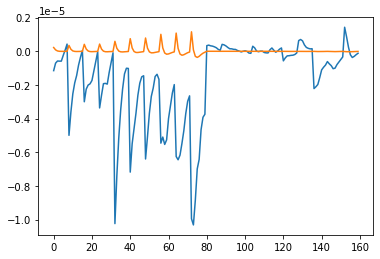

In [59]:
key = 'delta_Ob'
plt.plot(np.mean((derivatives_dict['WL_2'][key][1]-derivatives_dict['WL_2'][key][0]),axis=0)/delta[key])

plt.plot(-0.002*deriv['ob'])

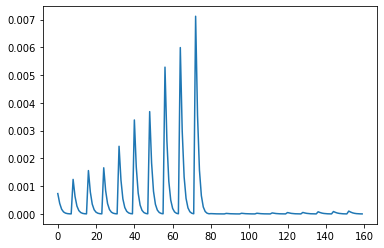

In [38]:
plt.plot(deriv['om'])

# IMNN

In [ ]:
import jax
import jax.numpy as jnp
from jax import random
from jax.experimental import stax, optimizers
from jax.experimental.stax import Dense, Relu, LeakyRelu, Concatenate
import imnn
import imnn.lfi
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

tfp = tensorflow_probability.substrates.jax
rng = jax.random.PRNGKey(0)



# MODEL -------

def CustomBranch(negative_slope=0.01):
    # Define a single branch of the model
    return stax.serial(
        Dense(900), LeakyRelu(negative_slope),
        Dense(800), LeakyRelu(negative_slope),
        Dense(100), Relu,
        Dense(100), Relu,
        Dense(1)  # Output layer for each branch
    )

def MyModel(number_of_branches=number_of_params):
    # Create multiple branches and concatenate their outputs
    branches = [CustomBranch() for _ in range(number_of_branches)]
    # Using FanOut and FanInSum to parallelize branches and then concatenate outputs
    return stax.serial(
        stax.FanOut(number_of_branches),
        stax.parallel(*branches),
        stax.FanInConcat(axis=-1)
    )


In [27]:
1

1

In [25]:
np.save('resume',[compressed_DV_VMIM,compressed_DV_NN,compressed_DV_MOPED])

# LFI

Need to load another environment for this...

In [1]:
import numpy as np
import copy
[compressed_DV_VMIM,compressed_DV_NN,compressed_DV_MOPED] = np.load('resume.npy',allow_pickle=True)

In [73]:
compressed_DV_MOPED_ = copy.deepcopy(compressed_DV_MOPED)

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, "/global/cfs/cdirs/des/mgatti/tensorflow_115/")
import pydelfi.priors as priors
import tensorflow as tf
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import emcee as mc
import numpy as np
theta2d_expected_mean = [ 0.75,0.3,0.5,0.5]

def initial_parameters(theta, relative_sigma):
    """
    This is not randomise the initial position of the
    :param theta: list/a
    rray of parameter values
    :param relative_sigma: controls variance of random draws
    :return: the theta array but with random shifts
    """
    theta = np.array(theta)
    return np.random.normal(theta, np.abs(theta * relative_sigma))

result_dir = '../../../../../../../pscratch/sd/m/mgatti/temp2/'       

lower = np.array([0.15, 0.55,0.15,0])
upper = np.array([0.49, 0.99,0.85,1])
    
lower_mc = np.array([0.15, 0.55,0.2,0])
upper_mc = np.array([0.49, 0.99,0.85,1])
    
prior = priors.Uniform(lower, upper)


In [22]:
compressed_dict = dict()
#compressed_dict['VMIM'] = compressed_DV_VMIM
#compressed_dict['NN'] = compressed_DV_NN
compressed_dict['MOPED'] = copy.deepcopy(compressed_DV_MOPED)


# combine statistics
for key in compressed_dict.keys():
    compressed_dict[key]['WL_23_COMBINED'] = copy.deepcopy(compressed_dict[key]['WL_2'])
    compressed_dict[key]['WL_23_COMBINED']['DV'] = np.hstack([compressed_dict[key]['WL_2']['DV'],compressed_dict[key]['WL_3']['DV']])
    compressed_dict[key]['WL_23_COMBINED']['target'] = np.hstack([compressed_dict[key]['WL_2']['target'],compressed_dict[key]['WL_3']['target']])
    
    #compressed_dict[key]['WL_23_COMBINED'] = copy.deepcopy(compressed_dict[key]['WL_2'])
    
# process MOPED better ---------
key = 'MOPED'
for statistics in compressed_dict[key].keys():
    std_  = 100*np.std(compressed_dict[key][statistic]['DV'],axis=0)
    median_ = np.median(compressed_dict[key][statistic]['DV'],axis=0)
    
    compressed_dict[key][statistic]['DV'] =     compressed_dict[key][statistic]['DV']/std_-median_+0.5
    compressed_dict[key][statistic]['target'] = compressed_dict[key][statistic]['target']/std_-median_+0.5

In [23]:
key = 'MOPED'
for statistics in compressed_dict[key].keys():

    compressed_dict[key][statistic]['DV'] =     np.clip(compressed_dict[key][statistic]['DV'],0,1)[:,:4]
    compressed_dict[key][statistic]['target'] = np.clip(compressed_dict[key][statistic]['target'],0,1)[:4]

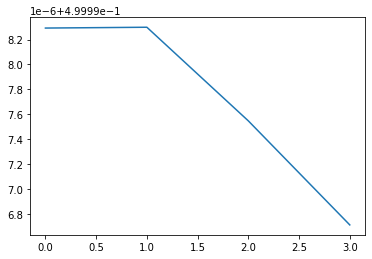

In [24]:
plt.plot(compressed_dict[key][statistic]['target'] )

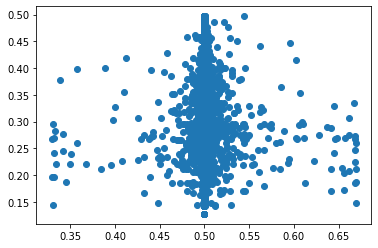

In [86]:
plt.scatter(compressed_dict[key][statistic]['DV'][:,0],compressed_dict[key][statistic]['params'][:,0])

In [ ]:
DelfiEnsemble_dict['{0}_{1}'.format(key,statistic)].log_posterior_stacked([ 0.3,0.75,0.5,0.5],data=data)[0][0]

In [26]:
DelfiEnsemble_dict = dict()
import getdist
from getdist import plots, MCSamples


theta2d_expected_mean = [ 0.3,0.75,0.5,0.5]
chains_dict = dict()
chains_dict = np.load('/pscratch/sd/m/mgatti/LFI/chains_CMB_lensing/chains.npy',allow_pickle=True).item()


count = 8901000
for key in ['MOPED']:#compressed_dict.keys():
    
    
    for statistic in ['WL_2']: #compressed_dict[key].keys():
       # if not '{0}_{1}'.format(key,statistic) in chains_dict.keys():
            
            print ('{0}_{1}'.format(key,statistic))
            nn = len(lower)
            base = count # any time you re-run it, please increase this by the number of NDEs. Otherwise you'd need to restart the notebook.
            count += 4
            #NDEs = #[ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=nn, n_data=compressed_dict[key][statistic]['DV'].shape[1], n_hiddens=[60,60], n_mades=4, act_fun=tf.tanh, index=base + 0)]#,
                    #ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=nn, n_data=compressed_dict[key][statistic]['DV'].shape[1], n_hiddens=[60,60], n_mades=5, act_fun=tf.tanh, index=base + 1),
                    #ndes.MixtureDensityNetwork(n_parameters=nn, n_data=compressed_dict[key][statistic]['DV'].shape[1], n_components=4, n_hidden=[60,60], activations=[tf.tanh, tf.tanh], index=base + 2),
            NDEs =         [ndes.MixtureDensityNetwork(n_parameters=nn, n_data=compressed_dict[key][statistic]['DV'].shape[1], n_components=5, n_hidden=[60,60], activations=[tf.tanh, tf.tanh], index=base + 3)]

            #NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=nn, n_data=compressed_dict[key][statistic]['DV'].shape[1], n_hiddens=[60,60], n_mades=4, act_fun=tf.tanh, index=base + 0),
            #        ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=nn, n_data=compressed_dict[key][statistic]['DV'].shape[1], n_hiddens=[60,60], n_mades=5, act_fun=tf.tanh, index=base + 1),
            #        ndes.MixtureDensityNetwork(n_parameters=nn, n_data=compressed_dict[key][statistic]['DV'].shape[1], n_components=4, n_hidden=[60,60], activations=[tf.tanh, tf.tanh], index=base + 2),
            #        ndes.MixtureDensityNetwork(n_parameters=nn, n_data=compressed_dict[key][statistic]['DV'].shape[1], n_components=5, n_hidden=[60,60], activations=[tf.tanh, tf.tanh], index=base + 3)]
#


            pn = ['p{0}'.format(i) for i in range(nn)]


            import os
            try:
                os.mkdir(result_dir+'/'+str(base))
            except:
                pass
            try:
                os.system('rm '+result_dir+'/'+str(base)+'/*')
            except:
                pass

            DelfiEnsemble = delfi.Delfi(np.array(np.median(compressed_dict[key][statistic]['DV'],axis=0), dtype = 'float'), prior, NDEs,
                                                param_limits = [lower, upper],
                                                param_names = pn, 
                                                results_dir = result_dir+'/'+str(base)+'/')
            #,False,False]

            DelfiEnsemble.load_simulations(np.array(np.clip(0,1.2,compressed_dict[key][statistic]['DV']), dtype = 'float'), compressed_dict[key][statistic]['params'])
            DelfiEnsemble.train_ndes()
            DelfiEnsemble_dict['{0}_{1}'.format(key,statistic)] = DelfiEnsemble

            #
    




            n_dim2d=nn
            n_burn2d=1000
            n_steps2d = 10000
            n_walkers2d = nn * n_dim2d

            theta0_2d = np.array([list(initial_parameters(theta2d_expected_mean, 0.01)) for i in range(n_walkers2d)])



            def prior_term2d(theta2d):
                p_ = theta2d.T
                for i in range(len(p_)):
                    if ((p_[i]<lower[i])|(p_[i]>upper[i])):
                        return  - np.inf
                return  0.



            def log_posterior2d_temp(theta2d, data):
                return DelfiEnsemble_dict['{0}_{1}'.format(key,statistic)].log_posterior_stacked([theta2d.T],data=data)[0][0] + prior_term2d(theta2d)


           # sampler2d_ = mc.EnsembleSampler(n_walkers2d, n_dim2d, log_posterior2d_temp,args=(np.mean(compressed_DV[stat]['DV'],axis=0),))
            sampler2d_ = mc.EnsembleSampler(n_walkers2d, n_dim2d, log_posterior2d_temp,args=(compressed_dict[key][statistic]['target'],))

            _ = sampler2d_.run_mcmc(theta0_2d, n_burn2d+n_steps2d)

            final_chain = sampler2d_.get_chain()
            chains_dict['{0}_{1}'.format(key,statistic)] = final_chain




            tt = '{0}_{1}'.format(key,statistic)
            
            samples = MCSamples(samples=[chains_dict[tt][:,:,0].flatten(),chains_dict[tt][:,:,1].flatten()],
                                names = ['Om','s8'],labels = [r'\Omega_{\rm m}',r'S_8'],
                                label=key,
                               settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.2})


            fom = 1/np.sqrt(np.linalg.det(samples.cov()))
            print ('{0}_{1}'.format(key,statistic), fom)
            
            
            np.save('/pscratch/sd/m/mgatti/LFI/chains_CMB_lensing/chains',chains_dict)

#plt.figure(figsize=(4,4))
#
#g = plots.get_subplot_plotter()
##g.triangle_plot([samples4_c,ss],['Om','s8'],label = ['all','cl'] ,shaded=True)
#
#
#g.triangle_plot(ss,['Om','s8'],legend_loc='upper right' ,markers = [0.26,0.82*np.sqrt(0.26/0.3)]) #,shaded=True)
#plt.show()

MOPED_WL_2



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().






Training:  15%|█▍        | 74/500 [01:15<07:07,  1.00s/it, train loss=nan, val loss=nan]    

INFO:tensorflow:Restoring parameters from ../../../../../../../pscratch/sd/m/mgatti/temp2//8901000/graph_checkpoint


Training:  15%|█▍        | 74/500 [01:16<07:17,  1.03s/it, train loss=nan, val loss=nan]
/global/homes/m/mgatti/.conda/envs/bfd_env3/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Removed no burn in
MOPED_WL_2 57255.533489703084


<Figure size 288x288 with 0 Axes>

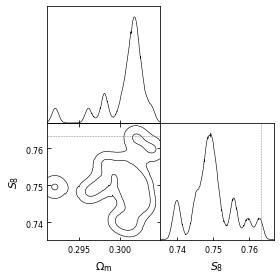

In [28]:
plt.figure(figsize=(4,4))

g = plots.get_subplot_plotter()
#g.triangle_plot([samples4_c,ss],['Om','s8'],label = ['all','cl'] ,shaded=True)


g.triangle_plot([samples],['Om','s8'],legend_loc='upper right' ,markers = [0.26,0.82*np.sqrt(0.26/0.3)]) #,shaded=True)
plt.show()

In [52]:
for key in ['MOPED']:#compressed_dict.keys():
    
    
    for statistic in compressed_dict[key].keys():
        if not '{0}_{1}'.format(key,statistic) in chains_dict.keys():
            





            n_dim2d=nn
            n_burn2d=1000
            n_steps2d = 10000
            n_walkers2d = nn * n_dim2d

            theta0_2d = np.array([list(initial_parameters(theta2d_expected_mean, 0.01)) for i in range(n_walkers2d)])



            def prior_term2d(theta2d):
                p_ = theta2d.T
                for i in range(len(p_)):
                    if ((p_[i]<lower[i])|(p_[i]>upper[i])):
                        return  - np.inf
                return  0.



            def log_posterior2d_temp(theta2d, data):
                return DelfiEnsemble_dict['{0}_{1}'.format(key,statistic)].log_posterior_stacked([theta2d.T],data=data)[0][0] + prior_term2d(theta2d)


           # sampler2d_ = mc.EnsembleSampler(n_walkers2d, n_dim2d, log_posterior2d_temp,args=(np.mean(compressed_DV[stat]['DV'],axis=0),))
            sampler2d_ = mc.EnsembleSampler(n_walkers2d, n_dim2d, log_posterior2d_temp,args=(compressed_dict[key][statistic]['target'],))

            _ = sampler2d_.run_mcmc(theta0_2d, n_burn2d+n_steps2d)

            final_chain = sampler2d_.get_chain()
            chains_dict['{0}_{1}'.format(key,statistic)] = final_chain




            tt = '{0}_{1}'.format(key,statistic)
            
            samples = MCSamples(samples=[chains_dict[tt][:,:,0].flatten(),chains_dict[tt][:,:,1].flatten()],
                                names = ['Om','s8'],labels = [r'\Omega_{\rm m}',r'S_8'],
                                label=key,
                               settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.2})


            fom = 1/np.sqrt(np.linalg.det(samples.cov()))
            print ('{0}_{1}'.format(key,statistic), fom)
            
            
            np.save('/pscratch/sd/m/mgatti/LFI/chains_CMB_lensing/chains',chains_dict)


/global/homes/m/mgatti/.conda/envs/bfd_env3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


ValueError: Probability function returned NaN

In [66]:
chains_dict.keys()

dict_keys(['VMIM_WL_23', 'VMIM_WL_3', 'VMIM_WL_2', 'VMIM_WL_23_COMBINED', 'NN_WL_23', 'NN_WL_3', 'NN_WL_2', 'NN_WL_23_COMBINED', 'MOPED_WL_23', 'MOPED_WL_2'])

In [67]:
theta2d_expected_mean = [ 0.3,0.75,0.5,0.5]
chains_dict = np.load('/pscratch/sd/m/mgatti/LFI/chains_CMB_lensing/chains.npy',allow_pickle=True).item()

for tt in chains_dict.keys():

    #for statistic in chains_dict[key].keys():
       # if  '{0}_{1}'.format(key,statistic) in chains_dict.keys():






            #tt = '{0}_{1}'.format(key,statistic)
            samples = MCSamples(samples=[chains_dict[tt][:,:,0].flatten(),chains_dict[tt][:,:,1].flatten()],
                                names = ['Om','s8'],labels = [r'\Omega_{\rm m}',r'S_8'],
                                label=key,
                               settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.2})


            fom = 1/np.sqrt(np.linalg.det(samples.cov()))
            print ('{0} {1:2.0f}'.format(tt, fom))


Removed no burn in
VMIM_WL_23 1069
Removed no burn in
VMIM_WL_3 168
Removed no burn in
VMIM_WL_2 926
Removed no burn in
VMIM_WL_23_COMBINED 1202
Removed no burn in
NN_WL_23 903
Removed no burn in
NN_WL_3 160
Removed no burn in
NN_WL_2 851
Removed no burn in
NN_WL_23_COMBINED 1024
Removed no burn in
MOPED_WL_23 40384
Removed no burn in
MOPED_WL_2 57256


In [ ]:
chains_dict.keys()

In [ ]:
g = plots.get_subplot_plotter()
#g.triangle_plot([samples4_c,ss],['Om','s8'],label = ['all','cl'] ,shaded=True)

g.triangle_plot(ss[2:],['Om','s8'],legend_loc='upper right' ,markers = [0.26,0.82*np.sqrt(0.26/0.3)]) #,shaded=True)
plt.show()

# Loop VMIM + NN

In [ ]:
compressed_DV_VMIM = dict()
compressed_DV_NN = dict()

for statistic in ['WL_23','WL_3','WL_2']:
    # Dirac + Dark Grid simulations and target datavector:
    DD = np.load('/global/cfs/cdirs/des/mgatti/CMB_lensing/DV/SBI_forecast/compression/compression_data_combined.npy',allow_pickle=True).item()
    stat = DD['stat']
    mask = DD['mask']
    target = DD['data']

    # Load derivatives & covariance matrix
    derivatives_dict = np.load('/global/cfs/cdirs/des/mgatti/CMB_lensing/DV/SBI_forecast/MOPED_derivatives.npy',allow_pickle=True).item()


    #statistic = 'WL_2' # let's start from something simple, i.e., WL second moments ------------------2
    number_of_params = 4 # Omega_m, S8, w, A_IA
    weights_loss_MSE = np.array([ 50, 50, 1,  5 ]) # this reflects the fact we care more about Om S8 than w when using a MSE loss (which is barely learned)
    weights_loss_MSE = weights_loss_MSE[:number_of_params]



    '''
    Data set preparation -------------------------------------------
    '''
    additional_mask = stat[statistic]['params'][:,2]>0.1
    # these are the pars/DV that will be used for the compression.
    pars = jnp.array(stat[statistic]['params'][mask&additional_mask,:number_of_params])
    dv = jnp.array(stat[statistic]['dv'][mask&additional_mask,:])

    # these are the pars/DV that will be used for the LFI step later on
    pars_LFI = jnp.array(stat[statistic]['params'][(~mask)&additional_mask,:number_of_params])
    dv_LFI = jnp.array(stat[statistic]['dv'][(~mask)&additional_mask,:])


    len_dv = dv.shape[1]  
    samples = dv.shape[0]

    # split into training & validation for the compression -------
    rng = default_rng()
    numbers = rng.choice(samples , size=3000, replace=False)
    special = np.in1d(np.arange(samples ),numbers)


    pars_train = jnp.array(pars[~special])
    pars_val =  jnp.array(pars[special])
    dv_train = jnp.array(dv[~special])
    dv_val = jnp.array(dv[special])

    # normalise the DV
    dv_val =    np.clip(0.5+0.2 * ( dv_val-np.median( dv,axis=0)) / np.std( dv, axis=0) ,-0.5,1.5)
    dv_train =  np.clip(0.5+0.2 * ( dv_train-np.median( dv,axis=0)) / np.std( dv, axis=0) ,-0.5,1.5)
    dv_LFI =    np.clip(0.5+0.2 * ( dv_LFI-np.median( dv,axis=0)) / np.std( dv, axis=0) ,-0.5,1.5)
    dv_target = np.clip(0.5+0.2 * ( target[statistic]['dv']-np.median( dv,axis=0)) / np.std( dv, axis=0) ,-0.5,1.5)


    
    
    
    
    # transform into tensorflow arrays 
    dset_x = tf.data.Dataset.from_tensor_slices(pars_train)
    dset_x_val = tf.data.Dataset.from_tensor_slices(pars_val)
    dset_y = tf.data.Dataset.from_tensor_slices(dv_train)
    dset_y_val = tf.data.Dataset.from_tensor_slices(dv_val)
    dset = tf.data.Dataset.zip((dset_x, dset_y))
    dset_y_val = tf.data.Dataset.zip((dset_x_val, dset_y_val))


    #Caches the dataset in memory or on disk, which can improve performance
    dset = dset.cache()
    dset_y_val = dset_y_val.cache()

    # Repeats the dataset indefinitely, 
    # allowing for multiple epochs of training without needing to manually reset the iterator.
    dset = dset.repeat()
    dset_y_val = dset_y_val.repeat()

    #Randomly shuffles the elements of the dataset using a buffer of size 2000.
    dset = dset.shuffle(dv_train.shape[0])
    dset_y_val = dset_y_val.shuffle(dv_val.shape[0])

    #Groups the dataset elements into batches of 128. 
    # Batching is essential for training models efficiently, allowing for parallel computation over a batch of data.
    size_batch = 32
    number_of_batches_train = math.ceil(dv_train.shape[0] / size_batch)
    number_of_batches_val = math.ceil(dv_val.shape[0] / size_batch)

    dset = dset.batch(size_batch)
    dset_y_val = dset_y_val.batch(size_batch)

    #Creates an iterator that will return the elements of the dataset as NumPy arrays. 
    # This allows for easy integration with code expecting NumPy input.
    dset = dset.as_numpy_iterator()
    dset_y_val = dset_y_val.as_numpy_iterator()


    
    
    
    
    
    '''
    Let's train first only the compression part using a MSE loss
    '''

    rng_seq = hk.PRNGSequence(42)

    model_compressor = hk.without_apply_rng(hk.transform(lambda x: Compressor()(x)))
    optimizer = optax.chain(optax.adam(1e-4))
    params_compressor = model_compressor.init(next(rng_seq), jnp.zeros([1, len_dv]))
    opt_state = optimizer.init(params_compressor)


    def average_loss(params, rng_key, batches):
        total_loss = 0.0
        for batch in batches:
            x, y = batch
            z = model_compressor.apply(params, y)
            total_loss += jnp.mean(weights_loss_MSE*((z - x) ** 2))
        return total_loss / len(batches)

    @jax.jit
    def update_mse(params, rng_key, opt_state, batches):
        """Single SGD update step using MSE loss averaged over multiple batches."""
        loss = average_loss(params, rng_key, batches)
        grads = jax.grad(lambda p: average_loss(p, rng_key, batches))(params)
        updates, new_opt_state = optimizer.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        return loss, new_params, new_opt_state

    @jax.jit
    def validate_model_mse(params, batches, rng_key):
        """Validate the model using MSE loss averaged over multiple batches."""
        val_loss = average_loss(params, rng_key, batches)
        return val_loss

    def get_batches(iterator, num_batches):
        return [next(iterator) for _ in range(num_batches)]



    losses = []
    val_losses = []
    no_improve_count = 0
    no_improve_threshold = 25  # Set X to the number of iterations you'll allow without any decrease in loss
    best_loss = float('inf')
    best_params_compressor = None  # Initialize a variable to store the best parameters


    for epoch in (range(150)):
        epoch_losses = []
        for batch_index in range(number_of_batches_train):
            # Assuming get_batches fetches the next batch from dset
            training_batch = next(dset)
            loss, params_compressor, opt_state = update_mse(params_compressor, next(rng_seq), opt_state, [training_batch])
            epoch_losses.append(loss)

        # Average the losses for the epoch
        avg_epoch_loss = np.mean(epoch_losses)
        losses.append(avg_epoch_loss)

        # Validation
        val_losses_accum = []
        for _ in range(number_of_batches_val):
            validation_batch = next(dset_y_val)
            val_loss = validate_model_mse(params_compressor, [validation_batch], next(rng_seq))
            val_losses_accum.append(val_loss)

        # Average validation loss
        avg_val_loss = np.mean(val_losses_accum)
        val_losses.append(avg_val_loss)

        # Update best loss and check for early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            no_improve_count = 0
            best_params_compressor = copy.deepcopy(params_compressor)
        else:
            no_improve_count += 1

        if no_improve_count >= no_improve_threshold:
            print(f"Stopping early due to no decrease in loss after {no_improve_threshold} iterations.")
            break

        print(f"Epoch {epoch}: Training Loss = {avg_epoch_loss}, Validation Loss = {avg_val_loss}")




    print ('BEST LOSS ',best_loss)


    z_LFI = model_compressor.apply(best_params_compressor, dv_LFI) 
    z_target = model_compressor.apply(best_params_compressor, np.array(dv_target).reshape(1,-1))
    z_target = z_target[0]

    plt.title('LOSS [compressor only]--')
    plt.plot(losses[3:])
    plt.plot(val_losses[3:])
    #plt.ylim([-10,2])
    plt.show()


    MSE = np.mean((z_LFI[:,0]-pars_LFI[:,0])**2)
    MSE1 = np.mean((z_LFI[:,1]-pars_LFI[:,1])**2)
    MSE2 = np.mean((z_LFI[:,2]-pars_LFI[:,2])**2)
    MSE3 = np.mean((z_LFI[:,3]-pars_LFI[:,3])**2)

    fig, ax = plt.subplots(1,4,sharex=False,sharey=False, figsize=(12,3)) 
    ax[0].scatter(pars_LFI[:,0],z_LFI[:,0],s=0.1)
    ax[0].scatter([0.26],[z_target[0]])
    ax[0].set_title('MSE {0:2.4f}'.format(MSE))
    ax[1].set_title('MSE {0:2.4f}'.format(MSE1))
    ax[1].scatter(pars_LFI[:,1],z_LFI[:,1],s=0.1)
    ax[1].scatter([0.82*np.sqrt(0.26/0.3)],[z_target[1]])
    ax[2].set_title('MSE {0:2.4f}'.format(MSE2))
    ax[2].scatter(pars_LFI[:,2],z_LFI[:,2],s=0.1)
    ax[2].scatter([-1.+1.2],[z_target[2]])
    ax[3].set_title('MSE {0:2.4f}'.format(MSE3))
    ax[3].scatter(pars_LFI[:,3],z_LFI[:,3],s=0.1)
    ax[3].scatter([0.5],[z_target[3]])
    plt.show()

    
    
    
    
    compressed_DV_NN[statistic] = dict()
    compressed_DV_NN[statistic]['params'] = np.array(pars_LFI)
    compressed_DV_NN[statistic]['DV'] =  np.array(z_LFI)
    compressed_DV_NN[statistic]['target'] =  np.array(z_target)
    
    
    
    
    
    
    
    
    
    '''
    Let's train the NDEs only, using the best parameters for the compression part using
    the mutual information loss
    '''

    rng_seq = hrng_seq = hk.PRNGSequence(42)
    model_logp = hk.without_apply_rng(hk.transform(lambda x,y : AffineFlow()().log_prob(x,bijector_kwargs={'nvp%d'%i:{'cond':y} for i in range(4)})))
    params_flow = model_logp.init(next(rng_seq), jnp.zeros([1, number_of_params]), jnp.zeros([1, number_of_params]))

    optimizer = optax.chain(optax.adam(1e-4))
    opt_state = optimizer.init(params_flow)


    def average_loss(params, rng_key, batches, best_params_compressor):
        total_loss = 0.0
        for batch in batches:
            x, y = batch
            z = model_compressor.apply(best_params_compressor, y)
            logp = model_logp.apply(params, x, z)
            total_loss += -jnp.mean(logp)
        return total_loss / len(batches)

    @jax.jit
    def update(params, rng_key, opt_state, batches):
        """Single SGD update step averaged over multiple batches."""
        loss = average_loss(params, rng_key, batches, best_params_compressor)
        grads = jax.grad(lambda p: average_loss(p, rng_key, batches, best_params_compressor))(params)
        updates, new_opt_state = optimizer.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        return loss, new_params, new_opt_state

    @jax.jit
    def validate_model(params, batches, rng_key):
        """Validate the model using average loss over multiple batches."""
        val_loss = average_loss(params, rng_key, batches, best_params_compressor)
        return val_loss

    def get_batches(iterator, num_batches):
        return [next(iterator) for _ in range(num_batches)]









    losses = []
    val_losses = []
    no_improve_count = 0
    no_improve_threshold = 15  # Set X to the number of iterations you'll allow without any decrease in loss
    best_loss = float('inf')
    best_params_flow = None  # Initialize a variable to store the best parameters


    for epoch in (range(150)):
        epoch_losses = []
        for batch_index in range(number_of_batches_train):
            # Assuming get_batches fetches the next batch from dset
            training_batch = next(dset)
            loss, params_flow, opt_state = update(params_flow, next(rng_seq), opt_state, [training_batch])
            epoch_losses.append(loss)



        # Average the losses for the epoch
        avg_epoch_loss = np.mean(epoch_losses)
        losses.append(avg_epoch_loss)

        # Validation
        val_losses_accum = []
        for _ in range(number_of_batches_val):
            validation_batch = next(dset_y_val)
            val_loss = validate_model(params_flow, [validation_batch], next(rng_seq))
            val_losses_accum.append(val_loss)

        # Average validation loss
        avg_val_loss = np.mean(val_losses_accum)
        val_losses.append(avg_val_loss)

        # Update best loss and check for early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            no_improve_count = 0
            best_params_flow = copy.deepcopy(params_flow)
        else:
            no_improve_count += 1

        if no_improve_count >= no_improve_threshold:
            print(f"Stopping early due to no decrease in loss after {no_improve_threshold} iterations.")
            break

        print(f"Epoch {epoch}: Training Loss = {avg_epoch_loss}, Validation Loss = {avg_val_loss}")



    plt.title('LOSS')
    plt.plot(losses[5:])
    plt.plot(val_losses[5:])
    #plt.ylim([-10,2])
    plt.show()
    
    


    '''
    Let's train the compression+NDEs together, using the best parameters from the previous two steps as a starting point
    '''

    rng_seq = hk.PRNGSequence(42)

    model_compressor = hk.without_apply_rng(hk.transform(lambda x: Compressor()(x)))
    model_logp = hk.without_apply_rng(hk.transform(lambda x,y : AffineFlow()().log_prob(x,bijector_kwargs={'nvp%d'%i:{'cond':y} for i in range(4)})))
    model_sample = hk.transform(lambda n,y : AffineFlow()().sample(n, seed=hk.next_rng_key(), bijector_kwargs={'nvp%d'%i:{'cond':y} for i in range(4)}))

    # copying this from before ~ ------------
    params_compressor = copy.deepcopy(best_params_compressor)
    params_flow = copy.deepcopy(best_params_flow)
    params = hk.data_structures.merge(params_flow, params_compressor)


    optimizer = optax.chain(optax.adam(1e-5))
    opt_state = optimizer.init(params)


    def average_loss(params, rng_key, batches):
        total_loss = 0.0
        for batch in batches:
            x, y = batch
            z = model_compressor.apply(params, y)  # Assuming you're using some pre-trained parameters or another method here
            logp = model_logp.apply(params, x, z)
            total_loss += -jnp.mean(logp)

        total_loss_mse = 0.0
        for batch in batches:
            x, y = batch
            z = model_compressor.apply(params, y)
            total_loss_mse += jnp.mean(weights_loss_MSE*((z - x) ** 2))

        avg_loss = (5*jnp.log(total_loss_mse)+total_loss)/len(batches)
        return avg_loss

    @jax.jit
    def update(params, rng_key, opt_state, batches):
        """Single SGD update step averaged over multiple batches."""
        loss = average_loss(params, rng_key, batches)
        grads = jax.grad(lambda p: average_loss(p, rng_key, batches))(params)
        updates, new_opt_state = optimizer.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        return loss, new_params, new_opt_state

    @jax.jit
    def validate_model(params, batches, rng_key):
        """Validate the model using average loss over multiple batches."""
        val_loss = average_loss(params, rng_key, batches)
        return val_loss

    def get_batches(iterator, num_batches):
        return [next(iterator) for _ in range(num_batches)]

    # Training loop adjustments


    losses = []
    val_losses = []
    no_improve_count = 0
    no_improve_threshold = 15  # Set X to the number of iterations you'll allow without any decrease in loss
    best_loss = float('inf')
    best_params = None

    for epoch in (range(250)):
        epoch_losses = []
        for batch_index in range(number_of_batches_train):
            # Assuming get_batches fetches the next batch from dset
            training_batch = next(dset)
            loss, params, opt_state = update(params, next(rng_seq), opt_state, [training_batch])
            epoch_losses.append(loss)



        # Average the losses for the epoch
        avg_epoch_loss = np.mean(epoch_losses)
        losses.append(avg_epoch_loss)

        # Validation
        val_losses_accum = []
        for _ in range(number_of_batches_val):
            validation_batch = next(dset_y_val)
            val_loss = validate_model(params, [validation_batch], next(rng_seq))
            val_losses_accum.append(val_loss)

        # Average validation loss
        avg_val_loss = np.mean(val_losses_accum)
        val_losses.append(avg_val_loss)

        # Update best loss and check for early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            no_improve_count = 0
            best_params = copy.deepcopy(params)
        else:
            no_improve_count += 1

        if no_improve_count >= no_improve_threshold:
            print(f"Stopping early due to no decrease in loss after {no_improve_threshold} iterations.")
            break

        print(f"Epoch {epoch}: Training Loss = {avg_epoch_loss}, Validation Loss = {avg_val_loss}")


    print('BEST LOSS', best_loss)
    # predict ------
    batch = next(dset)
    x,y = batch

    z_LFI = model_sample.apply(best_params, next(rng_seq), n=dv_LFI.shape[0], y=model_compressor.apply(best_params, dv_LFI))
    z_target = model_sample.apply(best_params, next(rng_seq), n=1, y=model_compressor.apply(best_params, np.array(dv_target).reshape(1,-1)))
    z_target = z_target[0]


    # predict ------
    batch = next(dset)
    x,y = batch

    z_LFI = model_compressor.apply(best_params, dv_LFI)
    z_target = model_compressor.apply(best_params, np.array(dv_target).reshape(1,-1))

    #z_LFI = model_compressor.apply(best_params_compressor, dv_LFI)
    #z_target = model_compressor.apply(best_params_compressor, np.array(dv_target).reshape(1,-1))

    z_target = z_target[0]


    plt.title('LOSS')
    plt.plot(losses)
    plt.plot(val_losses)
    #plt.ylim([-10,2])
    plt.show()


    MSE = np.mean((z_LFI[:,0]-pars_LFI[:,0])**2)
    MSE1 = np.mean((z_LFI[:,1]-pars_LFI[:,1])**2)
    MSE2 = np.mean((z_LFI[:,2]-pars_LFI[:,2])**2)
    MSE3 = np.mean((z_LFI[:,3]-pars_LFI[:,3])**2)

    fig, ax = plt.subplots(1,4,sharex=False,sharey=False, figsize=(12,3)) 
    ax[0].scatter(pars_LFI[:,0],z_LFI[:,0],s=0.1)
    ax[0].scatter([0.26],[z_target[0]])
    ax[0].set_title('MSE {0:2.4f}'.format(MSE))
    ax[1].set_title('MSE {0:2.4f}'.format(MSE1))
    ax[1].scatter(pars_LFI[:,1],z_LFI[:,1],s=0.1)
    ax[1].scatter([0.82*np.sqrt(0.26/0.3)],[z_target[1]])
    ax[2].set_title('MSE {0:2.4f}'.format(MSE2))
    ax[2].scatter(pars_LFI[:,2],z_LFI[:,2],s=0.1)
    ax[2].scatter([-1.+1.2],[z_target[2]])
    ax[3].set_title('MSE {0:2.4f}'.format(MSE3))
    ax[3].scatter(pars_LFI[:,3],z_LFI[:,3],s=0.1)
    ax[3].scatter([0.5],[z_target[3]])
    plt.show()



    #compressed_DV_VMIM = dict()  
    compressed_DV_VMIM[statistic] = dict()
    compressed_DV_VMIM[statistic]['params'] = np.array(pars_LFI)
    compressed_DV_VMIM[statistic]['DV'] =  np.array(z_LFI)
    compressed_DV_VMIM[statistic]['target'] =  np.array(z_target)


Epoch 0: Training Loss = 0.21851707994937897, Validation Loss = 0.11328344792127609
Epoch 1: Training Loss = 0.08346399664878845, Validation Loss = 0.06970608979463577
Epoch 2: Training Loss = 0.07235196232795715, Validation Loss = 0.06907860934734344
Epoch 3: Training Loss = 0.06972338259220123, Validation Loss = 0.06480562686920166
Epoch 4: Training Loss = 0.0693025141954422, Validation Loss = 0.06024503707885742
Epoch 5: Training Loss = 0.06525600701570511, Validation Loss = 0.06163594499230385
Epoch 6: Training Loss = 0.06256946921348572, Validation Loss = 0.06640935689210892
Epoch 7: Training Loss = 0.06232627481222153, Validation Loss = 0.0643809512257576
Epoch 8: Training Loss = 0.061241514980793, Validation Loss = 0.057714954018592834
Epoch 9: Training Loss = 0.058511778712272644, Validation Loss = 0.06696676462888718
Epoch 10: Training Loss = 0.0596596896648407, Validation Loss = 0.05351930111646652
Epoch 11: Training Loss = 0.0581011101603508, Validation Loss = 0.058414600789

statistic: ----  WL_23


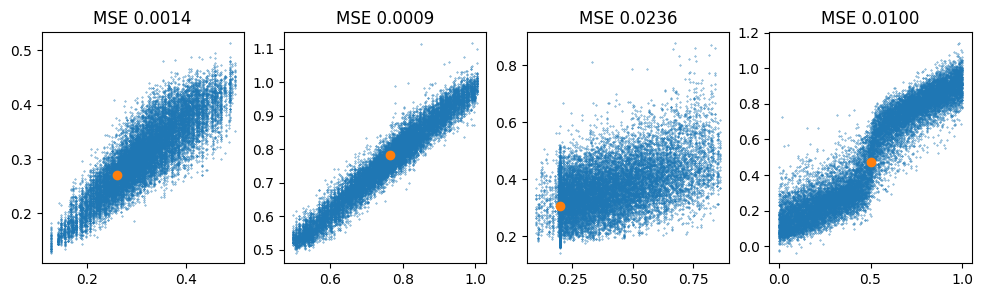

statistic: ----  WL_3


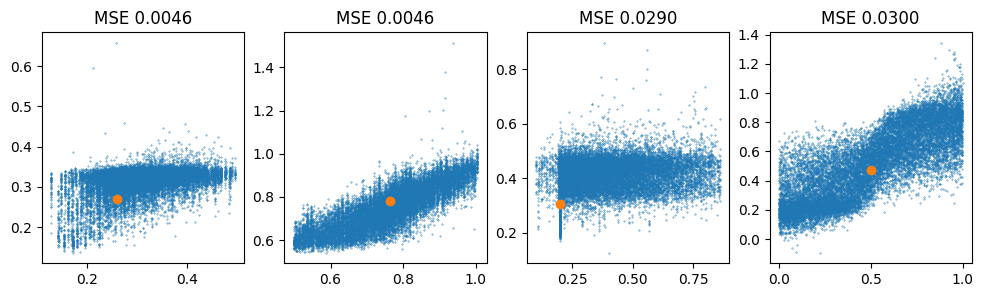

statistic: ----  WL_2


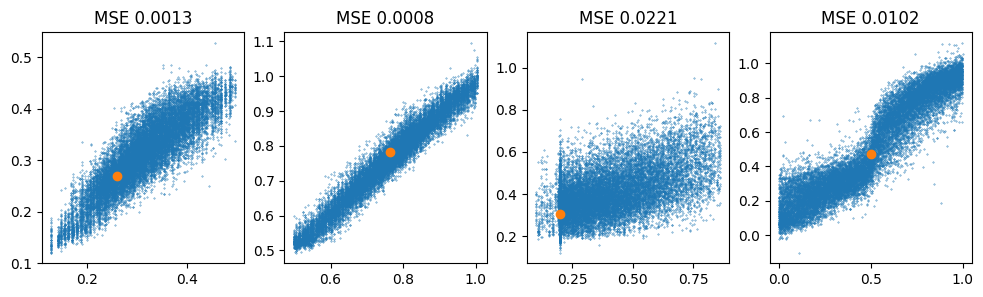

In [140]:
for statistic in compressed_DV_VMIM.keys():
    print ('statistic: ---- ',statistic)
    MSE =  np.mean((compressed_DV_NN[statistic]['DV'][:,0]-compressed_DV_NN[statistic]['params'][:,0])**2)
    MSE1 = np.mean((compressed_DV_NN[statistic]['DV'][:,1]-compressed_DV_NN[statistic]['params'][:,1])**2)
    MSE2 = np.mean((compressed_DV_NN[statistic]['DV'][:,2]-compressed_DV_NN[statistic]['params'][:,2])**2)
    MSE3 = np.mean((compressed_DV_NN[statistic]['DV'][:,3]-compressed_DV_NN[statistic]['params'][:,3])**2)

    fig, ax = plt.subplots(1,4,sharex=False,sharey=False, figsize=(12,3)) 
    ax[0].scatter(compressed_DV_NN[statistic]['params'][:,0],compressed_DV_NN[statistic]['DV'][:,0],s=0.1)
    ax[0].scatter([0.26],[z_target[0]])
    ax[0].set_title('MSE {0:2.4f}'.format(MSE))
    ax[1].set_title('MSE {0:2.4f}'.format(MSE1))
    ax[1].scatter(compressed_DV_NN[statistic]['params'][:,1],compressed_DV_NN[statistic]['DV'][:,1],s=0.1)
    ax[1].scatter([0.82*np.sqrt(0.26/0.3)],[z_target[1]])
    ax[2].set_title('MSE {0:2.4f}'.format(MSE2))
    ax[2].scatter(compressed_DV_NN[statistic]['params'][:,2],compressed_DV_NN[statistic]['DV'][:,2],s=0.1)
    ax[2].scatter([-1.+1.2],[z_target[2]])
    ax[3].set_title('MSE {0:2.4f}'.format(MSE3))
    ax[3].scatter(compressed_DV_NN[statistic]['params'][:,3],compressed_DV_NN[statistic]['DV'][:,3],s=0.1)
    ax[3].scatter([0.5],[z_target[3]])
    plt.show()



statistic: ----  WL_23


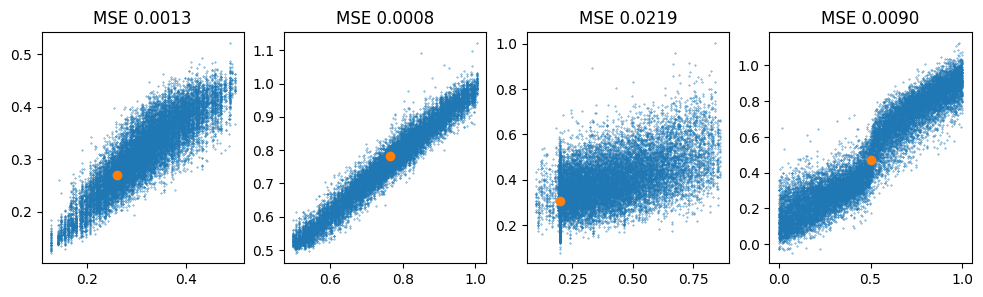

statistic: ----  WL_3


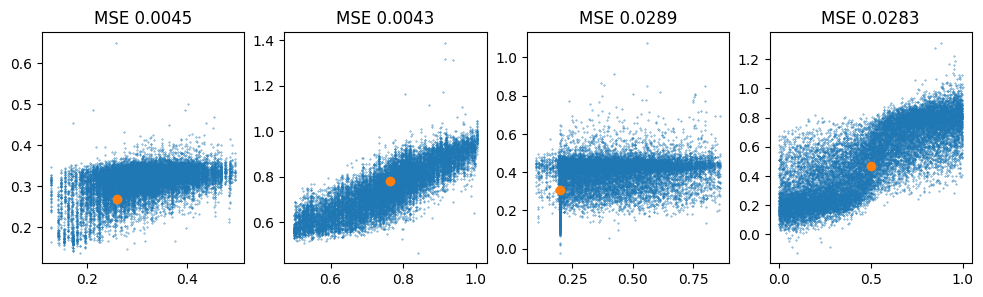

statistic: ----  WL_2


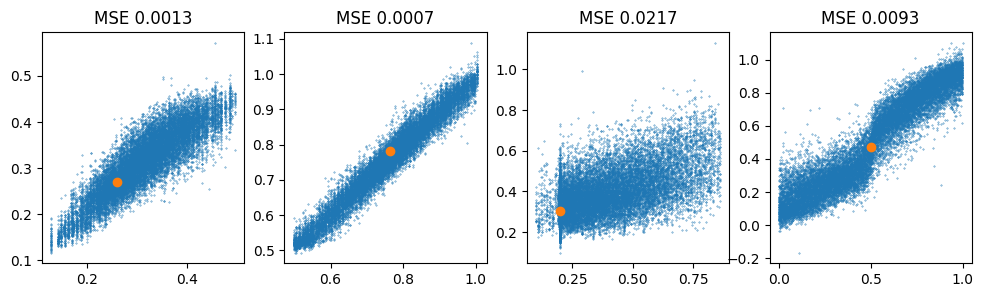

In [144]:
for statistic in compressed_DV_VMIM.keys():
    print ('statistic: ---- ',statistic)
    MSE =  np.mean((compressed_DV_VMIM[statistic]['DV'][:,0]-compressed_DV_VMIM[statistic]['params'][:,0])**2)
    MSE1 = np.mean((compressed_DV_VMIM[statistic]['DV'][:,1]-compressed_DV_VMIM[statistic]['params'][:,1])**2)
    MSE2 = np.mean((compressed_DV_VMIM[statistic]['DV'][:,2]-compressed_DV_VMIM[statistic]['params'][:,2])**2)
    MSE3 = np.mean((compressed_DV_VMIM[statistic]['DV'][:,3]-compressed_DV_VMIM[statistic]['params'][:,3])**2)

    fig, ax = plt.subplots(1,4,sharex=False,sharey=False, figsize=(12,3)) 
    ax[0].scatter(compressed_DV_VMIM[statistic]['params'][:,0],compressed_DV_VMIM[statistic]['DV'][:,0],s=0.1)
    ax[0].scatter([0.26],[z_target[0]])
    ax[0].set_title('MSE {0:2.4f}'.format(MSE))
    ax[1].set_title('MSE {0:2.4f}'.format(MSE1))
    ax[1].scatter(compressed_DV_VMIM[statistic]['params'][:,1],compressed_DV_VMIM[statistic]['DV'][:,1],s=0.1)
    ax[1].scatter([0.82*np.sqrt(0.26/0.3)],[z_target[1]])
    ax[2].set_title('MSE {0:2.4f}'.format(MSE2))
    ax[2].scatter(compressed_DV_VMIM[statistic]['params'][:,2],compressed_DV_VMIM[statistic]['DV'][:,2],s=0.1)
    ax[2].scatter([-1.+1.2],[z_target[2]])
    ax[3].set_title('MSE {0:2.4f}'.format(MSE3))
    ax[3].scatter(compressed_DV_VMIM[statistic]['params'][:,3],compressed_DV_VMIM[statistic]['DV'][:,3],s=0.1)
    ax[3].scatter([0.5],[z_target[3]])
    plt.show()



In [143]:
np.save('resume',[compressed_DV_VMIM,compressed_DV_NN,compressed_DV_MOPED])

In [ ]:
- VMIN: add some check on the size of the posterior for Om/S8 (yet another loss!)
- VMIN/NN: add another network dedicated to third moments. I guess this corresponds to almost combine the outputs?

- compress MOPED DVs just for fun? -> not really working